# Uncertainty Quantification Validation

The public datasets can be found at: https://archive.ics.uci.edu/datasets

In [ ]:
# load packages
from IPython.utils import io
import pandas as pd
import numpy as np
import copy
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import random
import warnings
warnings.filterwarnings('ignore')
import tqdm
import time
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import math
with io.capture_output() as captured:
    !pip install tensorflow
    !pip install mapie
    !pip install ngboost
    !pip install torch
!pip install 'lightgbm[scikit-learn]'
from lightgbm import LGBMRegressor
import mapie
from mapie.regression import MapieQuantileRegressor, MapieRegressor
from ngboost import NGBRegressor
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras import layers, models
from matplotlib.offsetbox import (AnnotationBbox, DrawingArea, OffsetImage,
                                  TextArea)
import scipy.stats

## Define helper functions.

In [3]:
# Define Neural Network
class MLP(torch.nn.Module):

  def __init__(self, input_dim):
    super().__init__()


    self.fc1 = torch.nn.Linear(input_dim, 200,  bias=True)
    self.fc2 = torch.nn.Linear(200,300,  bias=True)
    self.fc3 = torch.nn.Linear(300, 300,  bias=True)
    self.fc4 = torch.nn.Linear(300, 200,  bias=True)
    self.fc5 = torch.nn.Linear(200, 1,  bias=True)


    self.activation = torch.nn.ReLU()
    #self.activation = torch.nn.Sigmoid()
    self.drop_out = torch.nn.Dropout(0.5, inplace = False)
    self.drop = True

  def forward(self, x):

    if self.drop:
      res = self.fc1(x)
      res = self.activation(res)
      res = self.fc2(self.drop_out(res))
      res = self.activation(res)
      res = self.fc3(self.drop_out(res))
      res = self.activation(res)
      res = self.fc4(self.drop_out(res))
      res = self.activation(res)
      res = self.fc5(res)

    else:
      res = self.fc1(x)
      res = self.activation(res)
      res = self.fc2(res)
      res = self.activation(res)
      res = self.fc3(res)
      res = self.activation(res)
      res = self.fc4(res)

    return res


In [4]:
# define evaluate function
def evaluate(model, val_loader, loss):
  #model.eval()
  eval_loss = torch.nn.MSELoss()
  with torch.no_grad():
    loss_ev = 0
    for batch_x, batch_y in val_loader:
      batch_y = batch_y.unsqueeze(-1)
      y_pred = model(batch_x)
      loss_ev += eval_loss(batch_y, y_pred)

    loss_ev = loss_ev/len(val_loader)
  #model.train()
  return loss_ev


In [5]:
# define trainig function with early stop implementation
def train_nn(model, epochs, lr, train_loader, val_loader, loss):
  torch.manual_seed(99)
  # Optimizer
  optim = torch.optim.Adam(model.parameters(), lr = lr)
  #optim = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.5)
  loss_fn = loss()

  # early stopping
  max_iter = 20
  iter = 0
  best_loss = math.inf

  for epoch in range(epochs):

    for batch_x, batch_y in train_loader:

      model.train()
      optim.zero_grad()

      # forward pass
      batch_y = batch_y.unsqueeze(-1)
      y_pred = model(batch_x)# .squeeze(-1)
      # compute loss
      loss = loss_fn(batch_y, y_pred)
      ## back-prop
      loss.backward()
      # gradient step
      optim.step()

    current_loss = evaluate(model, val_loader, torch.nn.MSELoss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch}; Loss {current_loss}")

    if current_loss > best_loss:
      iter += 1
      if iter >= max_iter:
        print("early stopping")
        # return best model
        return best_model

    else:
      best_loss = current_loss
      iter = 0
      # save best model
      best_model = copy.deepcopy(model)

In [6]:
# define pre-processing function that creates dummies, scales and imputes NAs as 0
def pre_process(X, num_col, scaler):

  X.loc[:, num_col] = scaler.transform(X.loc[:, num_col])
  X_ohe = pd.get_dummies(X, dtype = int)
  X_ohe = X_ohe.fillna(0)

  return X_ohe


In [7]:
# from X, Y to dataloaders
def to_Tensor(X, Y):

  # tensors
  X_tensor = torch.from_numpy(X.values.astype("float32"))
  Y_tensor = torch.from_numpy(Y.values.astype("float32"))

  return X_tensor, Y_tensor

def to_DataSet(X_tensor, Y_tensor):

  # Dataset
  ds = TensorDataset(X_tensor, Y_tensor)

  return ds

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

def to_Loader(ds, batch_size):
  # tensors
  data_loader = DataLoader(ds, batch_size = batch_size, worker_init_fn=seed_worker, generator=g)

  return data_loader

In [8]:
# define functions to generate Monte Carlo predictions, both prediction intervals and predicted coverages
def MC_predictions(model, X_test_tensor, alpha, x):
  torch.manual_seed(99)
  # number of forward passes
  T = 5000
  # enable drop out
  for each_module in model.modules():
    if each_module.__class__.__name__.startswith("Dropout"):
      #print(each_module)
      each_module.train()

  for t in range(T):
    if t == 0:
      y_preds = model(X_test_tensor).detach()

    else:
      y_preds = torch.cat((y_preds, model(X_test_tensor).detach()), dim = 1)

  # return desired quantiles as lower and upper bounds
  lower = np.quantile(y_preds, alpha/2, axis = 1)
  upper = np.quantile(y_preds, 1-alpha/2, axis = 1)

  # disable drop out
  for each_module in model.modules():
    if each_module.__class__.__name__.startswith("Dropout"):
      each_module.eval()

  Y_pred =  model(X_test_tensor).detach()

  # PREDICTION OF COVERAGE
  upper_cdf = np.zeros(len(y_preds))
  lower_cdf = np.zeros(len(y_preds))
  coverages = np.zeros(len(y_preds))
  for i in range(len(y_preds)):
    # check if y_preds[i] is positive or negative
      delta = np.abs(Y_pred[i] * x)
      upper_cdf[i] =  np.array(y_preds[i] < Y_pred[i] + delta).mean()
      lower_cdf[i] = np.array(y_preds[i] < Y_pred[i] - delta).mean()
      coverages[i] = upper_cdf[i] - lower_cdf[i]

  return lower, upper, y_preds, coverages

In [9]:
# Functions to implement Nested CP
def nested_CP(y_preds, Y_cal):
  alphas = np.linspace(1, 0.0, num = 500)
  coverages = np.zeros(len(alphas))

  for idx, alpha in enumerate(alphas):

    lower = np.quantile(y_preds, alpha/2, axis = 1)
    upper = np.quantile(y_preds, 1- alpha/2, axis = 1)
    coverages[idx] = ((Y_cal > lower) & (Y_cal < upper)).mean()

  return coverages, alphas

def find_nearest(coverages, alphas, desired_alpha):

  desired_cov = 1 - desired_alpha
  coverages = np.asarray(coverages)
  idx = (np.abs(coverages - desired_cov)).argmin()

  return alphas[idx], coverages[idx]


# function implementing the Nested Conformalised Monte Carlo Drop-Out
def conf_MCDO(y_preds_cal, Y_cal,  model, X_test_tensor, alpha, x):
  torch.manual_seed(99)
  T = 5000
  # enable drop out
  for each_module in model.modules():
    if each_module.__class__.__name__.startswith("Dropout"):
      each_module.train()

  for t in range(T):
    if t == 0:
      y_preds = model(X_test_tensor).detach()

    else:
      y_preds = torch.cat((y_preds, model(X_test_tensor).detach()), dim = 1)


  # return desired quantiles as lower and upper bounds
  lower = np.quantile(y_preds, alpha/2, axis = 1)
  upper = np.quantile(y_preds, 1-alpha/2, axis = 1)

  # disable drop out
  for each_module in model.modules():
    if each_module.__class__.__name__.startswith("Dropout"):
      each_module.eval()


  coverages = np.zeros(len(X_test_tensor))
  naive_cov = np.zeros(len(X_test_tensor))

  for j in range(len(X_test_tensor)):

    Y_pred = model(X_test_tensor[j]).detach()
    delta = np.abs(Y_pred * x)
    q1 = np.array(y_preds[j] < Y_pred - delta).mean()
    q2 = np.array(y_preds[j] < Y_pred + delta).mean()

    coverage = 0
    naive = 0
    for i in range(len(y_preds_cal)):
      pred_i = y_preds_cal[i]
      y_pred_i = pred_i.mean()
      low = y_pred_i - np.abs(y_pred_i * x)
      up = y_pred_i + np.abs(y_pred_i * x)
      lower_cp = np.quantile(pred_i, q1)
      upper_cp = np.quantile(pred_i, q2)
      coverage += ((Y_cal.iloc[i] >= lower_cp) & (Y_cal.iloc[i] <= upper_cp ))/len(y_preds_cal)
      naive += ((Y_cal.iloc[i] >= low) & (Y_cal.iloc[i] <= up ))/len(y_preds_cal)
    coverages[j] = coverage
    naive_cov[j] = naive


  return lower, upper, coverages, naive_cov

In [10]:
# function to compute the Expected Calibration Error (ECE)
def ece(coverages, Y_pred, Y_test):

  Y_pred = np.array(Y_pred)
  coverages = np.array(coverages)
  # num of bins
  k = 10
  # to store results
  nom_cov = np.zeros(k)
  emp_cov = np.zeros(k)
  cols = np.zeros(k)
  size = np.zeros(k)
  ns = np.zeros(k)
  # compute user chosen interval
  delta = np.abs(Y_pred * x)
  lower = (Y_pred  - delta).reshape(len(Y_pred))
  upper = (Y_pred + delta).reshape(len(Y_pred))

  for i in range(k):
      #print("loop")
      shap = np.argwhere(np.logical_and(coverages >= (i)/k, coverages<= (i+1)/k )).shape[0]
      i_k = np.argwhere(np.logical_and(coverages >= (i)/k, coverages<= (i+1)/k )).reshape(shap)
      nom_cov[i] = np.mean(coverages[i_k])
      emp_cov[i] = np.mean( (Y_test[i_k] >= lower[i_k]) & (Y_test[i_k] <= upper[i_k]))
      cols[i] = np.mean(Y_test[i_k])
      size[i] = np.std(Y_test[i_k])
      ns[i] = len(i_k)

  emp_cov = pd.DataFrame(emp_cov).fillna(0)
  emp_cov = emp_cov[0]
  nom_cov = pd.DataFrame(nom_cov).fillna(0)
  nom_cov = nom_cov[0]
  ece = np.sum(np.abs(nom_cov - emp_cov)*ns)/ns.sum()

  return ece

In [11]:
# function to compute Brier Score
def Brier_score(coverages, Y_pred, Y_test):
    Y_pred = np.array(Y_pred)
    coverages = np.array(coverages)
    delta = np.abs(Y_pred * x)
    low = Y_pred - delta
    up = Y_pred + delta
    Y = ((Y_test < up) & (Y_test < low))*1
    score = np.sum((Y-coverages)**2)

    return score

## Run the cell that contains the desired dataset!

In [12]:
### BLOG ###
blog = pd.read_csv("DataSets/blogData_train.csv", header = None)
blog = blog.loc[blog.iloc[:, 280]!= np.nan,:]
# 281:  The target: the number of comments in the next 24 hours (relative to basetime)
Y = blog.iloc[:, 280]
#Y = Y.fillna(0)
X = blog.drop(blog.columns[280], axis = 1)

In [13]:
# STORE RESULTS
B = 20 # number of runs
N = 1000 # number of data points sampled
# to store results
coverage = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
width = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
ECE_res = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
brier = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })

In [14]:
# user chosen error level
alpha_nominal = 0.2
# error tolerance (used to construct intervals around the point predictions of +- x%)
x = 0.3
# batch size for data loader
batch_size = 64
# learning rate
lr = 0.001
# num. of epochs
epochs = 500
# set seed
torch.manual_seed(99)
np.random.seed(99)
random.seed(99)
# record start time
start = time.time()

for b in tqdm.tqdm(range(B)):
  # sample indeces
  index = np.random.choice(range(len(X)), 1000)
  X_fold = X.iloc[index,:]
  X_fold.reset_index(drop=True, inplace = True)
  Y_fold = Y.iloc[index]
  Y_fold.reset_index(drop=True, inplace = True)
  # train and test split
  X_train, X_test, Y_train, Y_test = train_test_split(X_fold, Y_fold, test_size = 0.25, random_state = 99)
  # get calibration data
  X_train, X_cal, Y_train, Y_cal = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 99)

  # reset indeces
  X_train.reset_index(drop = True, inplace = True)
  X_cal.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  Y_train.reset_index(drop = True, inplace = True)
  Y_cal.reset_index(drop = True, inplace = True)
  Y_test.reset_index(drop = True, inplace = True)
  print(X_train.shape)
  print(X_cal.shape)
  print(X_test.shape)
  # scale response
  mean = Y_train.mean()
  std = Y_train.std()
  Y_train = (Y_train - mean)/std
  Y_cal = (Y_cal - mean)/std
  Y_test = (Y_test - mean)/std
  # NEURAL NETWORK
  num_col = X.select_dtypes(include = [np.number]).columns
  # scale features
  scaler = StandardScaler()
  scaler.fit(X_train.loc[:, num_col])
  # ohe  
  X_train_ohe = pre_process(X_train.copy(deep = True), num_col, scaler)
  X_cal_ohe = pre_process(X_cal.copy(deep=True), num_col, scaler)
  X_test_ohe = pre_process(X_test.copy(deep = True), num_col, scaler)
  # align
  X_cal_ohe = X_cal_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  X_test_ohe = X_test_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  
  # train data  
  X_train_tensor, Y_train_tensor = to_Tensor(X_train_ohe, Y_train)
  ds_train = to_DataSet(X_train_tensor, Y_train_tensor)
  train_loader = to_Loader(ds_train, batch_size)
  # cal data
  X_cal_tensor, Y_cal_tensor = to_Tensor(X_cal_ohe, Y_cal)
  ds_cal = to_DataSet(X_cal_tensor, Y_cal_tensor)
  cal_loader = to_Loader(ds_cal, batch_size)
  # get test data
  X_test_tensor, Y_test_tensor = to_Tensor(X_test_ohe, Y_test)
  

  # NN model
  mlp = MLP(X_train_ohe.shape[1])
  train_nn(mlp, epochs, lr, train_loader, cal_loader, torch.nn.MSELoss)

  # train all models (Boost, Quantile RF, NN, NGBoost)
  # BOOST
  boost = GradientBoostingRegressor()
  boost.fit(X_train_ohe, Y_train)
  # NGBOOST
  ng = NGBRegressor()
  ng.fit(X_train_ohe, Y_train)

  ############ conform on cal data #############
  # naive CP on Boost
  y_pred_cal = boost.predict(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  q = np.quantile(scores, 1-alpha_nominal)

  # naive CP on NN
  y_pred_cal = np.array(mlp(X_cal_tensor).detach().squeeze(-1))
  n_cal = len(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  conf_q =  (1-alpha_nominal) *(n_cal)/(1+n_cal)
  q_nn = np.quantile(scores, conf_q)

  # CQR
  estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=1, verbose_eval=False)
  cqr = MapieQuantileRegressor(estimator, alpha = alpha_nominal)
  cqr.fit(X_train_ohe, Y_train,
          X_calib = X_cal_ohe, y_calib = Y_cal)

  # MC-Drop Out
  # no conf step

  # ConfMCDO
  lower, upper, y_preds_cal, confidence_mc = MC_predictions(mlp, X_cal_tensor, alpha_nominal, x)
  coverages, alphas = nested_CP(y_preds_cal, Y_cal)
  conformal_alpha, conformal_coverage = find_nearest(coverages, alphas, alpha_nominal)
  print("C-alpha", conformal_alpha)
  print("C-coverage", conformal_coverage)


  # NGBoost
  # no conf step

  # ---------------------------- get performance on test data for all models -------------------

  # BOOST
  y_pred_test = boost.predict(X_test_ohe)
  print("Boost MSE:", mse(Y_test,y_pred_test))
  lower_cp = y_pred_test - q
  upper_cp = y_pred_test + q
  coverage["CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["CP"].iloc[b] = (upper_cp - lower_cp).mean()
  
  # Neural Network
  y_pred_test = np.array(mlp(X_test_tensor).detach().squeeze(-1))
  print("NN MSE:", mse(Y_test, y_pred_test))
  lower_cp = y_pred_test - q_nn
  upper_cp = y_pred_test + q_nn
  coverage["nn_CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["nn_CP"].iloc[b] = (upper_cp - lower_cp).mean()

  # NGBoost
  Y_test_dist = ng.pred_dist(X_test_ohe)
  Y_pred_ng = ng.predict(X_test_ohe)
  loc = Y_test_dist.params["loc"]
  scale = Y_test_dist.params["scale"]
  lower_ng = loc + scipy.stats.norm.ppf(alpha_nominal/2) * scale
  upper_ng = loc + scipy.stats.norm.ppf(1-alpha_nominal/2) * scale
  coverage["NGB"].iloc[b] = ((Y_test > lower_ng) & (Y_test < upper_ng)).mean()
  width["NGB"].iloc[b] = (upper_ng - lower_ng).mean()
  # confidence
  delta = np.abs(Y_pred_ng * x)
  l = Y_pred_ng - delta
  u = Y_pred_ng + delta
  conf_ngb = scipy.stats.norm.cdf(u, Y_test_dist.loc, Y_test_dist.scale) - scipy.stats.norm.cdf(l, Y_test_dist.loc, Y_test_dist.scale)
  #ECE_res["NGB"].iloc[b] = ece(conf_ngb, Y_pred_ng, Y_test)
  brier["NGB"].iloc[b] = Brier_score(conf_ngb, Y_pred_ng, Y_test)

  # CQR
  Y_pred_cqr, y_pis = cqr.predict(X_test_ohe)
  coverage["CQR"].iloc[b] = ((Y_test > y_pis[:,0].reshape(y_pis.shape[0])) & (Y_test < y_pis[:,1].reshape(y_pis.shape[0]))).mean()
  width["CQR"].iloc[b] = (y_pis[:,1]- y_pis[:,0]).mean()

  # MC
  lower_mc, upper_mc, y_preds, conf_mc = MC_predictions(mlp, X_test_tensor, alpha_nominal, x)
  coverage["MC"].iloc[b] = ((Y_test > lower_mc) & (Y_test < upper_mc)).mean()
  width["MC"].iloc[b] = (upper_mc - lower_mc).mean()
  # should I make my prediction the mean of the MC distribution?
  #res = ece(conf_mc, y_preds.mean(axis = 1), Y_test)
  #ECE_res["MC"].iloc[b] = res
  brier["MC"].iloc[b] = Brier_score(conf_mc, y_preds.mean(axis = 1), Y_test)

  # ConfMC
  print("NN MSE:", mse(Y_test,mlp(X_test_tensor).detach()) )
  lower_conf, upper_conf, confidence, naive_cov = conf_MCDO(y_preds_cal, Y_cal, mlp, X_test_tensor, conformal_alpha, x)
  coverage["ConfMC"].iloc[b] = ((Y_test > lower_conf) & (Y_test < upper_conf)).mean()
  width["ConfMC"].iloc[b] = (upper_conf - lower_conf).mean()
  Y_pred = mlp(X_test_tensor).detach().squeeze(-1)
  brier["ConfMC"].iloc[b] = Brier_score(confidence, Y_pred, Y_test)
  #ECE_res["ConfMC"].iloc[b] = ece(confidence, y_preds.mean(axis = 1), Y_test)
  #ECE_res["CP"].iloc[b] = ece(naive_cov, y_preds.mean(axis = 1), Y_test)
  brier["CP"].iloc[b] = Brier_score(naive_cov, y_preds.mean(axis = 1), Y_test)

end = time.time()
print("Total Time:", end - start)

  0%|          | 0/20 [00:00<?, ?it/s]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.17129451036453247
Epoch 5; Loss 0.3032931089401245
Epoch 10; Loss 0.21711499989032745
Epoch 15; Loss 0.395927757024765
Epoch 20; Loss 0.415370374917984
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.1063 val_loss=0.0000 scale=2.0000 norm=1.0531
[iter 200] loss=-0.7496 val_loss=0.0000 scale=4.0000 norm=1.9391
[iter 300] loss=-1.3553 val_loss=0.0000 scale=2.0000 norm=0.9043
[iter 400] loss=-1.7343 val_loss=0.0000 scale=1.0000 norm=0.4396
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3206
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 121
[Ligh

  5%|▌         | 1/20 [01:20<25:21, 80.08s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.46144571900367737
Epoch 5; Loss 0.4509451389312744
Epoch 10; Loss 1.3656851053237915
Epoch 15; Loss 0.19176940619945526
Epoch 20; Loss 0.6819536089897156
Epoch 25; Loss 0.625329315662384
Epoch 30; Loss 0.4535346031188965
Epoch 35; Loss 1.2553740739822388
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.0248 val_loss=0.0000 scale=2.0000 norm=1.0226
[iter 200] loss=-0.9673 val_loss=0.0000 scale=2.0000 norm=0.9470
[iter 300] loss=-1.6876 val_loss=0.0000 scale=1.0000 norm=0.4392
[iter 400] loss=-2.1566 val_loss=0.0000 scale=2.0000 norm=0.8631
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins

 10%|█         | 2/20 [02:39<23:56, 79.79s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 2.907864809036255
Epoch 5; Loss 1.9717516899108887
Epoch 10; Loss 2.158607244491577
Epoch 15; Loss 2.7696094512939453
Epoch 20; Loss 1.9814976453781128
Epoch 25; Loss 2.7969810962677
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9999
[iter 100] loss=0.0918 val_loss=0.0000 scale=2.0000 norm=1.0297
[iter 200] loss=-0.6946 val_loss=0.0000 scale=2.0000 norm=0.9218
[iter 300] loss=-1.2408 val_loss=0.0000 scale=2.0000 norm=0.8842
[iter 400] loss=-1.5192 val_loss=0.0000 scale=1.0000 norm=0.4440
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3048
[LightGBM] [Info] Number of data points in the train set: 562, numbe

 15%|█▌        | 3/20 [03:58<22:32, 79.56s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 1.7795000076293945
Epoch 5; Loss 0.7985778450965881
Epoch 10; Loss 1.125207781791687
Epoch 15; Loss 0.4750584661960602
Epoch 20; Loss 0.3805180788040161
Epoch 25; Loss 0.618583083152771
Epoch 30; Loss 0.5010810494422913
Epoch 35; Loss 0.24959683418273926
Epoch 40; Loss 0.8486050963401794
Epoch 45; Loss 0.5247011780738831
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9997
[iter 100] loss=0.1219 val_loss=0.0000 scale=2.0000 norm=1.0438
[iter 200] loss=-0.6518 val_loss=0.0000 scale=2.0000 norm=0.9455
[iter 300] loss=-1.2383 val_loss=0.0000 scale=1.0000 norm=0.4465
[iter 400] loss=-1.4911 val_loss=0.0000 scale=1.0000 norm=0.4418
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

 20%|██        | 4/20 [05:23<21:41, 81.36s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 1.3757386207580566
Epoch 5; Loss 1.0320268869400024
Epoch 10; Loss 0.551460325717926
Epoch 15; Loss 0.5243992805480957
Epoch 20; Loss 0.9655588269233704
Epoch 25; Loss 1.5083593130111694
Epoch 30; Loss 0.7712020874023438
Epoch 35; Loss 0.9922593235969543
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.0846 val_loss=0.0000 scale=2.0000 norm=1.0319
[iter 200] loss=-0.7358 val_loss=0.0000 scale=2.0000 norm=0.9425
[iter 300] loss=-1.2405 val_loss=0.0000 scale=0.5000 norm=0.2199
[iter 400] loss=-1.5237 val_loss=0.0000 scale=1.0000 norm=0.4495
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3

 25%|██▌       | 5/20 [06:53<21:07, 84.47s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.03277020528912544
Epoch 5; Loss 0.081480473279953
Epoch 10; Loss 0.1386350393295288
Epoch 15; Loss 0.38608691096305847
Epoch 20; Loss 0.32059094309806824
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.0503 val_loss=0.0000 scale=2.0000 norm=1.0307
[iter 200] loss=-0.8170 val_loss=0.0000 scale=2.0000 norm=0.9469
[iter 300] loss=-1.5037 val_loss=0.0000 scale=2.0000 norm=0.8928
[iter 400] loss=-1.8545 val_loss=0.0000 scale=1.0000 norm=0.4249
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3004
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 119
[Li

 30%|███       | 6/20 [08:18<19:47, 84.80s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 1.4706997871398926
Epoch 5; Loss 1.171626329421997
Epoch 10; Loss 0.8887329697608948
Epoch 15; Loss 1.016558289527893
Epoch 20; Loss 1.3500590324401855
Epoch 25; Loss 0.8950726389884949
Epoch 30; Loss 0.8482114672660828
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.1093 val_loss=0.0000 scale=2.0000 norm=1.0667
[iter 200] loss=-0.5837 val_loss=0.0000 scale=2.0000 norm=0.9630
[iter 300] loss=-1.0749 val_loss=0.0000 scale=2.0000 norm=0.9021
[iter 400] loss=-1.3187 val_loss=0.0000 scale=0.5000 norm=0.2256
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3198
[LightGBM] [Info] Number of dat

 35%|███▌      | 7/20 [09:45<18:29, 85.38s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.2651158273220062
Epoch 5; Loss 0.2274976521730423
Epoch 10; Loss 0.22046403586864471
Epoch 15; Loss 0.24060149490833282
Epoch 20; Loss 0.274164080619812
Epoch 25; Loss 0.2100275307893753
Epoch 30; Loss 0.4649170935153961
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.0442 val_loss=0.0000 scale=2.0000 norm=1.0253
[iter 200] loss=-0.9019 val_loss=0.0000 scale=2.0000 norm=0.9410
[iter 300] loss=-1.6570 val_loss=0.0000 scale=2.0000 norm=0.8841
[iter 400] loss=-2.0836 val_loss=0.0000 scale=2.0000 norm=0.8615
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3126
[LightGBM] [Info] Number of 

 40%|████      | 8/20 [11:12<17:11, 85.98s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 1.0962965488433838
Epoch 5; Loss 0.6767920851707458
Epoch 10; Loss 0.41807058453559875
Epoch 15; Loss 0.8132076263427734
Epoch 20; Loss 0.5051655173301697
Epoch 25; Loss 0.4267023801803589
Epoch 30; Loss 0.5891433954238892
Epoch 35; Loss 0.6801404356956482
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9999
[iter 100] loss=-0.0168 val_loss=0.0000 scale=2.0000 norm=1.0101
[iter 200] loss=-1.0409 val_loss=0.0000 scale=2.0000 norm=0.9382
[iter 300] loss=-1.8477 val_loss=0.0000 scale=2.0000 norm=0.8697
[iter 400] loss=-2.3901 val_loss=0.0000 scale=2.0000 norm=0.8213
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin

 45%|████▌     | 9/20 [12:39<15:51, 86.49s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 3.327821731567383
Epoch 5; Loss 2.5547099113464355
Epoch 10; Loss 2.623525857925415
Epoch 15; Loss 2.5675902366638184
Epoch 20; Loss 1.5470572710037231
Epoch 25; Loss 2.4932711124420166
Epoch 30; Loss 2.1069154739379883
Epoch 35; Loss 3.1201791763305664
Epoch 40; Loss 2.6452906131744385
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9999
[iter 100] loss=0.0441 val_loss=0.0000 scale=2.0000 norm=1.0400
[iter 200] loss=-0.9094 val_loss=0.0000 scale=2.0000 norm=0.9173
[iter 300] loss=-1.3801 val_loss=0.0000 scale=1.0000 norm=0.4322
[iter 400] loss=-1.6577 val_loss=0.0000 scale=1.0000 norm=0.4130
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true

 50%|█████     | 10/20 [14:06<14:25, 86.58s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.2829471528530121
Epoch 5; Loss 0.3420984745025635
Epoch 10; Loss 0.3952476978302002
Epoch 15; Loss 0.49752339720726013
Epoch 20; Loss 0.5966616272926331
Epoch 25; Loss 0.528853178024292
Epoch 30; Loss 0.28461530804634094
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9999
[iter 100] loss=0.0994 val_loss=0.0000 scale=2.0000 norm=1.0539
[iter 200] loss=-0.6193 val_loss=0.0000 scale=2.0000 norm=0.9290
[iter 300] loss=-1.1793 val_loss=0.0000 scale=2.0000 norm=0.8684
[iter 400] loss=-1.4750 val_loss=0.0000 scale=1.0000 norm=0.4121
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3164
[LightGBM] [Info] Number of 

 55%|█████▌    | 11/20 [15:33<12:58, 86.49s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 1.8590126037597656
Epoch 5; Loss 1.6606508493423462
Epoch 10; Loss 1.8436447381973267
Epoch 15; Loss 1.9848827123641968
Epoch 20; Loss 1.8826961517333984
Epoch 25; Loss 1.8552974462509155
Epoch 30; Loss 1.9062050580978394
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9996
[iter 100] loss=0.1272 val_loss=0.0000 scale=4.0000 norm=2.1847
[iter 200] loss=-0.6395 val_loss=0.0000 scale=1.0000 norm=0.4885
[iter 300] loss=-1.0239 val_loss=0.0000 scale=0.5000 norm=0.2333
[iter 400] loss=-1.2160 val_loss=0.0000 scale=0.5000 norm=0.2264
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3037
[LightGBM] [Info] Number of d

 60%|██████    | 12/20 [16:58<11:29, 86.23s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.9840142726898193
Epoch 5; Loss 0.6230111122131348
Epoch 10; Loss 0.5377798080444336
Epoch 15; Loss 0.700695276260376
Epoch 20; Loss 0.593463659286499
Epoch 25; Loss 0.5730916857719421
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9999
[iter 100] loss=0.2191 val_loss=0.0000 scale=1.0000 norm=0.5539
[iter 200] loss=-0.4886 val_loss=0.0000 scale=0.5000 norm=0.2518
[iter 300] loss=-0.8914 val_loss=0.0000 scale=2.0000 norm=0.9868
[iter 400] loss=-1.2061 val_loss=0.0000 scale=1.0000 norm=0.4814
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3275
[LightGBM] [Info] Number of data points in the train set: 562, nu

 65%|██████▌   | 13/20 [18:25<10:05, 86.53s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.7595551013946533
Epoch 5; Loss 0.7180536389350891
Epoch 10; Loss 0.5578442215919495
Epoch 15; Loss 0.7486647963523865
Epoch 20; Loss 0.8503194451332092
Epoch 25; Loss 2.233130693435669
Epoch 30; Loss 0.7216453552246094
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9999
[iter 100] loss=0.1355 val_loss=0.0000 scale=2.0000 norm=1.0730
[iter 200] loss=-0.6310 val_loss=0.0000 scale=2.0000 norm=0.9683
[iter 300] loss=-1.1980 val_loss=0.0000 scale=2.0000 norm=0.9119
[iter 400] loss=-1.4753 val_loss=0.0000 scale=1.0000 norm=0.4465
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of da

 70%|███████   | 14/20 [19:52<08:38, 86.44s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 3.139773368835449
Epoch 5; Loss 3.064973831176758
Epoch 10; Loss 3.1056385040283203
Epoch 15; Loss 3.039027452468872
Epoch 20; Loss 3.0307626724243164
Epoch 25; Loss 3.0876827239990234
Epoch 30; Loss 3.1206300258636475
Epoch 35; Loss 2.9987716674804688
Epoch 40; Loss 3.253636121749878
Epoch 45; Loss 3.047636032104492
Epoch 50; Loss 3.060103416442871
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.0653 val_loss=0.0000 scale=2.0000 norm=1.0519
[iter 200] loss=-0.8162 val_loss=0.0000 scale=2.0000 norm=0.9422
[iter 300] loss=-1.4138 val_loss=0.0000 scale=1.0000 norm=0.4426
[iter 400] loss=-1.7548 val_loss=0.0000 scale=1.0000 norm=0.4245
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_row_wise=true` to remove the overhea

 75%|███████▌  | 15/20 [21:18<07:12, 86.51s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.4605778753757477
Epoch 5; Loss 0.41538628935813904
Epoch 10; Loss 0.4082789123058319
Epoch 15; Loss 0.48273348808288574
Epoch 20; Loss 0.40059664845466614
Epoch 25; Loss 0.42588794231414795
Epoch 30; Loss 0.41157960891723633
Epoch 35; Loss 0.42102935910224915
Epoch 40; Loss 0.44532763957977295
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.0499 val_loss=0.0000 scale=2.0000 norm=1.0280
[iter 200] loss=-0.9730 val_loss=0.0000 scale=2.0000 norm=0.9252
[iter 300] loss=-1.6829 val_loss=0.0000 scale=2.0000 norm=0.8637
[iter 400] loss=-2.0949 val_loss=0.0000 scale=2.0000 norm=0.8285
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

 80%|████████  | 16/20 [22:44<05:45, 86.26s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.41189053654670715
Epoch 5; Loss 0.2734805643558502
Epoch 10; Loss 0.49924707412719727
Epoch 15; Loss 0.6247867941856384
Epoch 20; Loss 1.208917260169983
Epoch 25; Loss 0.4704756736755371
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9999
[iter 100] loss=0.1450 val_loss=0.0000 scale=2.0000 norm=1.0620
[iter 200] loss=-0.6698 val_loss=0.0000 scale=2.0000 norm=0.9594
[iter 300] loss=-1.2873 val_loss=0.0000 scale=2.0000 norm=0.8717
[iter 400] loss=-1.6305 val_loss=0.0000 scale=0.5000 norm=0.2128
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3089
[LightGBM] [Info] Number of data points in the train set: 562,

 85%|████████▌ | 17/20 [24:10<04:18, 86.07s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.6092563271522522
Epoch 5; Loss 0.7729117274284363
Epoch 10; Loss 0.71076899766922
Epoch 15; Loss 0.9163210391998291
Epoch 20; Loss 1.0140095949172974
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9999
[iter 100] loss=0.1448 val_loss=0.0000 scale=4.0000 norm=2.1147
[iter 200] loss=-0.5905 val_loss=0.0000 scale=2.0000 norm=0.9398
[iter 300] loss=-1.1656 val_loss=0.0000 scale=1.0000 norm=0.4373
[iter 400] loss=-1.5275 val_loss=0.0000 scale=2.0000 norm=0.8552
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3226
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 117
[LightG

 90%|█████████ | 18/20 [25:37<02:53, 86.59s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.09369979053735733
Epoch 5; Loss 0.2355731725692749
Epoch 10; Loss 0.1345909833908081
Epoch 15; Loss 0.13859544694423676
Epoch 20; Loss 0.16405344009399414
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9997
[iter 100] loss=0.1344 val_loss=0.0000 scale=2.0000 norm=1.0562
[iter 200] loss=-0.6599 val_loss=0.0000 scale=2.0000 norm=0.9601
[iter 300] loss=-1.2290 val_loss=0.0000 scale=2.0000 norm=0.9214
[iter 400] loss=-1.5832 val_loss=0.0000 scale=1.0000 norm=0.4525
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3113
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 119
[L

 95%|█████████▌| 19/20 [26:57<01:24, 84.59s/it]

(562, 280)
(188, 280)
(250, 280)
Epoch 0; Loss 0.73856520652771
Epoch 5; Loss 0.6626796722412109
Epoch 10; Loss 0.6089041233062744
Epoch 15; Loss 0.7053718566894531
Epoch 20; Loss 1.1087462902069092
Epoch 25; Loss 0.7385001182556152
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9998
[iter 100] loss=0.0754 val_loss=0.0000 scale=2.0000 norm=1.0398
[iter 200] loss=-0.7940 val_loss=0.0000 scale=2.0000 norm=0.9582
[iter 300] loss=-1.4155 val_loss=0.0000 scale=2.0000 norm=0.9012
[iter 400] loss=-1.7467 val_loss=0.0000 scale=1.0000 norm=0.4540
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3223
[LightGBM] [Info] Number of data points in the train set: 562, nu

100%|██████████| 20/20 [28:17<00:00, 84.85s/it]

Total Time: 1697.067766904831


In [15]:
# COVERAGE
print("Average Coverage", coverage.mean(axis = 0))
print("Std. Dev of Coverage", coverage.std(axis = 0))

Average Coverage CP        0.7954
nn_CP     0.8344
CQR       0.8092
NGB       0.7324
MC        0.4968
ConfMC    0.8024
dtype: float64
Std. Dev of Coverage CP        0.030277
nn_CP     0.077022
CQR       0.029908
NGB       0.035133
MC        0.162764
ConfMC    0.028385
dtype: float64


In [16]:
# WIDTH
print("Average Width", width.mean(axis = 0))
print("Std. Dev of Width", width.std(axis = 0))

Average Width CP        0.282752
nn_CP     0.311051
CQR       0.508843
NGB       0.190607
MC        0.295066
ConfMC    0.637085
dtype: float64
Std. Dev of Width CP        0.123288
nn_CP     0.076154
CQR       0.126883
NGB       0.063547
MC        0.087653
ConfMC    0.266370
dtype: float64


In [18]:
# Brier Score
print("Average", brier.mean(axis = 0))
print("Std. Dev.", brier.std(axis = 0))

Average CP         90.476924
CQR         0.000000
NGB       164.606980
MC         81.323972
ConfMC    128.102030
dtype: float64
Std. Dev. CP        45.450132
CQR        0.000000
NGB       15.521116
MC        12.267364
ConfMC    46.808597
dtype: float64


In [21]:
### GPU KERNEL ###
kernel = pd.read_csv("DataSets/sgemm_product.csv")
# They say better use log, response is average of last 4 columns, 4 independent runs
Y = kernel.iloc[:, -4:].mean(axis = 1)
X = kernel.iloc[:, :-4]
print(X.shape)

(241600, 14)


In [22]:
# STORE RESULTS
B = 20 # number of runs
N = 1000 # number of data points sampled
# to store results
coverage = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
width = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
ECE_res = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
brier = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })

# user chosen error level
alpha_nominal = 0.2
# error tolerance (used to construct intervals around the point predictions of +- x%)
x = 0.3
# batch size for data loader
batch_size = 64
# learning rate
lr = 0.001
# num. of epochs
epochs = 500
# set seed
torch.manual_seed(99)
np.random.seed(99)
random.seed(99)
# record start time
start = time.time()

for b in tqdm.tqdm(range(B)):
  # sample indeces
  index = np.random.choice(range(len(X)), 1000)
  X_fold = X.iloc[index,:]
  X_fold.reset_index(drop=True, inplace = True)
  Y_fold = Y.iloc[index]
  Y_fold.reset_index(drop=True, inplace = True)
  # train and test split
  X_train, X_test, Y_train, Y_test = train_test_split(X_fold, Y_fold, test_size = 0.25, random_state = 99)
  # get calibration data
  X_train, X_cal, Y_train, Y_cal = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 99)

  # reset indeces
  X_train.reset_index(drop = True, inplace = True)
  X_cal.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  Y_train.reset_index(drop = True, inplace = True)
  Y_cal.reset_index(drop = True, inplace = True)
  Y_test.reset_index(drop = True, inplace = True)
  print(X_train.shape)
  print(X_cal.shape)
  print(X_test.shape)
  # scale response
  mean = Y_train.mean()
  std = Y_train.std()
  Y_train = (Y_train - mean)/std
  Y_cal = (Y_cal - mean)/std
  Y_test = (Y_test - mean)/std
  # NEURAL NETWORK
  num_col = X.select_dtypes(include = [np.number]).columns
  # scale features
  scaler = StandardScaler()
  scaler.fit(X_train.loc[:, num_col])
  # ohe  
  X_train_ohe = pre_process(X_train.copy(deep = True), num_col, scaler)
  X_cal_ohe = pre_process(X_cal.copy(deep=True), num_col, scaler)
  X_test_ohe = pre_process(X_test.copy(deep = True), num_col, scaler)
  # align
  X_cal_ohe = X_cal_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  X_test_ohe = X_test_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  
  # train data  
  X_train_tensor, Y_train_tensor = to_Tensor(X_train_ohe, Y_train)
  ds_train = to_DataSet(X_train_tensor, Y_train_tensor)
  train_loader = to_Loader(ds_train, batch_size)
  # cal data
  X_cal_tensor, Y_cal_tensor = to_Tensor(X_cal_ohe, Y_cal)
  ds_cal = to_DataSet(X_cal_tensor, Y_cal_tensor)
  cal_loader = to_Loader(ds_cal, batch_size)
  # get test data
  X_test_tensor, Y_test_tensor = to_Tensor(X_test_ohe, Y_test)
  

  # NN model
  mlp = MLP(X_train_ohe.shape[1])
  train_nn(mlp, epochs, lr, train_loader, cal_loader, torch.nn.MSELoss)

  # train all models (Boost, Quantile RF, NN, NGBoost)
  # BOOST
  boost = GradientBoostingRegressor()
  boost.fit(X_train_ohe, Y_train)
  # NGBOOST
  ng = NGBRegressor()
  ng.fit(X_train_ohe, Y_train)

  ############ conform on cal data #############
  # naive CP on Boost
  y_pred_cal = boost.predict(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  q = np.quantile(scores, 1-alpha_nominal)

  # naive CP on NN
  y_pred_cal = np.array(mlp(X_cal_tensor).detach().squeeze(-1))
  n_cal = len(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  conf_q =  (1-alpha_nominal) *(n_cal)/(1+n_cal)
  q_nn = np.quantile(scores, conf_q)

  # CQR
  estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=1, verbose_eval=False)
  cqr = MapieQuantileRegressor(estimator, alpha = alpha_nominal)
  cqr.fit(X_train_ohe, Y_train,
          X_calib = X_cal_ohe, y_calib = Y_cal)

  # MC-Drop Out
  # no conf step

  # ConfMCDO
  lower, upper, y_preds_cal, confidence_mc = MC_predictions(mlp, X_cal_tensor, alpha_nominal, x)
  coverages, alphas = nested_CP(y_preds_cal, Y_cal)
  conformal_alpha, conformal_coverage = find_nearest(coverages, alphas, alpha_nominal)
  print("C-alpha", conformal_alpha)
  print("C-coverage", conformal_coverage)


  # NGBoost
  # no conf step

  # ---------------------------- get performance on test data for all models -------------------

  # BOOST
  y_pred_test = boost.predict(X_test_ohe)
  print("Boost MSE:", mse(Y_test,y_pred_test))
  lower_cp = y_pred_test - q
  upper_cp = y_pred_test + q
  coverage["CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["CP"].iloc[b] = (upper_cp - lower_cp).mean()
  
  # Neural Network
  y_pred_test = np.array(mlp(X_test_tensor).detach().squeeze(-1))
  print("NN MSE:", mse(Y_test, y_pred_test))
  lower_cp = y_pred_test - q_nn
  upper_cp = y_pred_test + q_nn
  coverage["nn_CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["nn_CP"].iloc[b] = (upper_cp - lower_cp).mean()

  # NGBoost
  Y_test_dist = ng.pred_dist(X_test_ohe)
  Y_pred_ng = ng.predict(X_test_ohe)
  loc = Y_test_dist.params["loc"]
  scale = Y_test_dist.params["scale"]
  lower_ng = loc + scipy.stats.norm.ppf(alpha_nominal/2) * scale
  upper_ng = loc + scipy.stats.norm.ppf(1-alpha_nominal/2) * scale
  coverage["NGB"].iloc[b] = ((Y_test > lower_ng) & (Y_test < upper_ng)).mean()
  width["NGB"].iloc[b] = (upper_ng - lower_ng).mean()
  # confidence
  delta = np.abs(Y_pred_ng * x)
  l = Y_pred_ng - delta
  u = Y_pred_ng + delta
  conf_ngb = scipy.stats.norm.cdf(u, Y_test_dist.loc, Y_test_dist.scale) - scipy.stats.norm.cdf(l, Y_test_dist.loc, Y_test_dist.scale)
  #ECE_res["NGB"].iloc[b] = ece(conf_ngb, Y_pred_ng, Y_test)
  brier["NGB"].iloc[b] = Brier_score(conf_ngb, Y_pred_ng, Y_test)

  # CQR
  Y_pred_cqr, y_pis = cqr.predict(X_test_ohe)
  coverage["CQR"].iloc[b] = ((Y_test > y_pis[:,0].reshape(y_pis.shape[0])) & (Y_test < y_pis[:,1].reshape(y_pis.shape[0]))).mean()
  width["CQR"].iloc[b] = (y_pis[:,1]- y_pis[:,0]).mean()

  # MC
  lower_mc, upper_mc, y_preds, conf_mc = MC_predictions(mlp, X_test_tensor, alpha_nominal, x)
  coverage["MC"].iloc[b] = ((Y_test > lower_mc) & (Y_test < upper_mc)).mean()
  width["MC"].iloc[b] = (upper_mc - lower_mc).mean()
  # should I make my prediction the mean of the MC distribution?
  #res = ece(conf_mc, y_preds.mean(axis = 1), Y_test)
  #ECE_res["MC"].iloc[b] = res
  brier["MC"].iloc[b] = Brier_score(conf_mc, y_preds.mean(axis = 1), Y_test)

  # ConfMC
  print("NN MSE:", mse(Y_test,mlp(X_test_tensor).detach()) )
  lower_conf, upper_conf, confidence, naive_cov = conf_MCDO(y_preds_cal, Y_cal, mlp, X_test_tensor, conformal_alpha, x)
  coverage["ConfMC"].iloc[b] = ((Y_test > lower_conf) & (Y_test < upper_conf)).mean()
  width["ConfMC"].iloc[b] = (upper_conf - lower_conf).mean()
  Y_pred = mlp(X_test_tensor).detach().squeeze(-1)
  brier["ConfMC"].iloc[b] = Brier_score(confidence, Y_pred, Y_test)
  #ECE_res["ConfMC"].iloc[b] = ece(confidence, y_preds.mean(axis = 1), Y_test)
  #ECE_res["CP"].iloc[b] = ece(naive_cov, y_preds.mean(axis = 1), Y_test)
  brier["CP"].iloc[b] = Brier_score(naive_cov, y_preds.mean(axis = 1), Y_test)

end = time.time()
print("Total Time:", end - start)

  0%|          | 0/20 [00:00<?, ?it/s]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.4799553453922272
Epoch 5; Loss 0.2831864655017853
Epoch 10; Loss 0.33055683970451355
Epoch 15; Loss 0.35513970255851746
Epoch 20; Loss 0.23909799754619598
Epoch 25; Loss 0.22825275361537933
Epoch 30; Loss 0.19931566715240479
Epoch 35; Loss 0.3213895857334137
Epoch 40; Loss 0.18157149851322174
Epoch 45; Loss 0.2295551300048828
Epoch 50; Loss 0.09501815587282181
Epoch 55; Loss 0.1767880767583847
Epoch 60; Loss 0.13134820759296417
Epoch 65; Loss 0.1618088036775589
Epoch 70; Loss 0.1392040103673935
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.8275 val_loss=0.0000 scale=1.0000 norm=0.6689
[iter 200] loss=0.4653 val_loss=0.0000 scale=1.0000 norm=0.6112
[iter 300] loss=0.1965 val_loss=0.0000 scale=1.0000 norm=0.5710
[iter 400] loss=0.0439 val_loss=0.0000 scale=1.0000 norm=0.5407
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Inf

  5%|▌         | 1/20 [01:15<23:51, 75.32s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.442126989364624
Epoch 5; Loss 0.20465320348739624
Epoch 10; Loss 0.39440616965293884
Epoch 15; Loss 0.27120256423950195
Epoch 20; Loss 0.22521217167377472
Epoch 25; Loss 0.22863586246967316
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9997
[iter 100] loss=0.6598 val_loss=0.0000 scale=1.0000 norm=0.6185
[iter 200] loss=0.2611 val_loss=0.0000 scale=1.0000 norm=0.5578
[iter 300] loss=0.0449 val_loss=0.0000 scale=1.0000 norm=0.5312
[iter 400] loss=-0.0835 val_loss=0.0000 scale=0.5000 norm=0.2596
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 562, num

 10%|█         | 2/20 [02:30<22:30, 75.04s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.074830412864685
Epoch 5; Loss 0.41500917077064514
Epoch 10; Loss 0.38898026943206787
Epoch 15; Loss 0.3634997308254242
Epoch 20; Loss 0.4311923086643219
Epoch 25; Loss 0.2832481861114502
Epoch 30; Loss 0.3537449836730957
Epoch 35; Loss 0.14865848422050476
Epoch 40; Loss 0.3220645487308502
Epoch 45; Loss 0.18527984619140625
Epoch 50; Loss 0.17431187629699707
Epoch 55; Loss 0.2716265618801117
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7609 val_loss=0.0000 scale=2.0000 norm=1.2959
[iter 200] loss=0.3633 val_loss=0.0000 scale=2.0000 norm=1.1737
[iter 300] loss=0.1087 val_loss=0.0000 scale=1.0000 norm=0.5483
[iter 400] loss=-0.0326 val_loss=0.0000 scale=0.5000 norm=0.2627
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `for

 15%|█▌        | 3/20 [03:46<21:24, 75.59s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.417655110359192
Epoch 5; Loss 0.6175567507743835
Epoch 10; Loss 0.4884756803512573
Epoch 15; Loss 0.5148530006408691
Epoch 20; Loss 0.3629303276538849
Epoch 25; Loss 0.32352641224861145
Epoch 30; Loss 0.46224236488342285
Epoch 35; Loss 0.4065537452697754
Epoch 40; Loss 0.4023381173610687
Epoch 45; Loss 0.41898202896118164
Epoch 50; Loss 0.4227207899093628
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7703 val_loss=0.0000 scale=1.0000 norm=0.6431
[iter 200] loss=0.4097 val_loss=0.0000 scale=1.0000 norm=0.5769
[iter 300] loss=0.1712 val_loss=0.0000 scale=1.0000 norm=0.5442
[iter 400] loss=0.0484 val_loss=0.0000 scale=0.5000 norm=0.2640
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overh

 20%|██        | 4/20 [05:02<20:12, 75.76s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.539939284324646
Epoch 5; Loss 0.551631510257721
Epoch 10; Loss 0.45635247230529785
Epoch 15; Loss 0.7061986327171326
Epoch 20; Loss 0.3135758340358734
Epoch 25; Loss 0.6428690552711487
Epoch 30; Loss 0.7318783402442932
Epoch 35; Loss 0.44486764073371887
Epoch 40; Loss 0.6156510710716248
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9997
[iter 100] loss=0.7041 val_loss=0.0000 scale=2.0000 norm=1.2726
[iter 200] loss=0.3053 val_loss=0.0000 scale=1.0000 norm=0.5845
[iter 300] loss=0.0513 val_loss=0.0000 scale=1.0000 norm=0.5465
[iter 400] loss=-0.0705 val_loss=0.0000 scale=0.5000 norm=0.2637
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


 25%|██▌       | 5/20 [06:17<18:53, 75.58s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.406933069229126
Epoch 5; Loss 0.3282318115234375
Epoch 10; Loss 0.19292782247066498
Epoch 15; Loss 0.17397505044937134
Epoch 20; Loss 0.2134556770324707
Epoch 25; Loss 0.13269154727458954
Epoch 30; Loss 0.22200779616832733
Epoch 35; Loss 0.12591499090194702
Epoch 40; Loss 0.09130889922380447
Epoch 45; Loss 0.1475679725408554
Epoch 50; Loss 0.11801749467849731
Epoch 55; Loss 0.12528352439403534
Epoch 60; Loss 0.11168547719717026
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7054 val_loss=0.0000 scale=2.0000 norm=1.2864
[iter 200] loss=0.3285 val_loss=0.0000 scale=1.0000 norm=0.5861
[iter 300] loss=0.0999 val_loss=0.0000 scale=1.0000 norm=0.5500
[iter 400] loss=-0.0173 val_loss=0.0000 scale=1.0000 norm=0.5278
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing 

 30%|███       | 6/20 [07:33<17:41, 75.83s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.6055985689163208
Epoch 5; Loss 0.9095392227172852
Epoch 10; Loss 0.6439822316169739
Epoch 15; Loss 0.6023476719856262
Epoch 20; Loss 0.7303009033203125
Epoch 25; Loss 0.6051738262176514
Epoch 30; Loss 0.689931333065033
Epoch 35; Loss 0.38567015528678894
Epoch 40; Loss 0.45605388283729553
Epoch 45; Loss 0.645886242389679
Epoch 50; Loss 0.6000300049781799
Epoch 55; Loss 0.6484283804893494
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9997
[iter 100] loss=0.7483 val_loss=0.0000 scale=2.0000 norm=1.2980
[iter 200] loss=0.4035 val_loss=0.0000 scale=1.0000 norm=0.5980
[iter 300] loss=0.1377 val_loss=0.0000 scale=1.0000 norm=0.5643
[iter 400] loss=-0.0203 val_loss=0.0000 scale=0.5000 norm=0.2720
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_r

 35%|███▌      | 7/20 [08:50<16:29, 76.10s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.762406051158905
Epoch 5; Loss 0.42787015438079834
Epoch 10; Loss 0.16874821484088898
Epoch 15; Loss 0.3530604839324951
Epoch 20; Loss 0.38559046387672424
Epoch 25; Loss 0.2748316824436188
Epoch 30; Loss 0.2405356615781784
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9992
[iter 100] loss=0.7526 val_loss=0.0000 scale=2.0000 norm=1.2976
[iter 200] loss=0.3951 val_loss=0.0000 scale=1.0000 norm=0.5944
[iter 300] loss=0.1456 val_loss=0.0000 scale=1.0000 norm=0.5573
[iter 400] loss=-0.0017 val_loss=0.0000 scale=0.5000 norm=0.2657
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data p

 40%|████      | 8/20 [10:06<15:10, 75.88s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.61847323179245
Epoch 5; Loss 0.43073728680610657
Epoch 10; Loss 0.3584231436252594
Epoch 15; Loss 0.360419899225235
Epoch 20; Loss 0.22187264263629913
Epoch 25; Loss 0.3124789893627167
Epoch 30; Loss 0.2534242570400238
Epoch 35; Loss 0.26597678661346436
Epoch 40; Loss 0.23122958838939667
Epoch 45; Loss 0.2418290376663208
Epoch 50; Loss 0.27348023653030396
Epoch 55; Loss 0.3049335181713104
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9997
[iter 100] loss=0.7701 val_loss=0.0000 scale=1.0000 norm=0.6552
[iter 200] loss=0.4246 val_loss=0.0000 scale=1.0000 norm=0.5994
[iter 300] loss=0.1637 val_loss=0.0000 scale=1.0000 norm=0.5638
[iter 400] loss=0.0333 val_loss=0.0000 scale=0.5000 norm=0.2711
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_

 45%|████▌     | 9/20 [11:22<13:56, 76.04s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.086531162261963
Epoch 5; Loss 0.6963996887207031
Epoch 10; Loss 0.5274294018745422
Epoch 15; Loss 0.5323566794395447
Epoch 20; Loss 0.8175603747367859
Epoch 25; Loss 0.3941064774990082
Epoch 30; Loss 0.6233906745910645
Epoch 35; Loss 0.5063850283622742
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9993
[iter 100] loss=0.6941 val_loss=0.0000 scale=1.0000 norm=0.6282
[iter 200] loss=0.3750 val_loss=0.0000 scale=1.0000 norm=0.5770
[iter 300] loss=0.1436 val_loss=0.0000 scale=1.0000 norm=0.5410
[iter 400] loss=0.0140 val_loss=0.0000 scale=0.5000 norm=0.2618
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 54
[Lig

 50%|█████     | 10/20 [12:38<12:40, 76.00s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.34506043791770935
Epoch 5; Loss 0.39126062393188477
Epoch 10; Loss 0.12188271433115005
Epoch 15; Loss 0.20273995399475098
Epoch 20; Loss 0.1857290416955948
Epoch 25; Loss 0.15800994634628296
Epoch 30; Loss 0.20963753759860992
Epoch 35; Loss 0.08448075503110886
Epoch 40; Loss 0.11224310845136642
Epoch 45; Loss 0.0753847286105156
Epoch 50; Loss 0.11435604095458984
Epoch 55; Loss 0.09476233273744583
Epoch 60; Loss 0.13119535148143768
Epoch 65; Loss 0.12060454487800598
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7812 val_loss=0.0000 scale=1.0000 norm=0.6544
[iter 200] loss=0.4129 val_loss=0.0000 scale=1.0000 norm=0.5944
[iter 300] loss=0.1388 val_loss=0.0000 scale=1.0000 norm=0.5532
[iter 400] loss=-0.0257 val_loss=0.0000 scale=0.5000 norm=0.2631
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise mul

 55%|█████▌    | 11/20 [13:55<11:25, 76.21s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.6924163699150085
Epoch 5; Loss 0.45629605650901794
Epoch 10; Loss 0.4222346842288971
Epoch 15; Loss 0.32806316018104553
Epoch 20; Loss 0.29770204424858093
Epoch 25; Loss 0.3587300777435303
Epoch 30; Loss 0.30517908930778503
Epoch 35; Loss 0.2631390392780304
Epoch 40; Loss 0.2333124876022339
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9997
[iter 100] loss=0.6569 val_loss=0.0000 scale=1.0000 norm=0.6124
[iter 200] loss=0.2389 val_loss=0.0000 scale=1.0000 norm=0.5585
[iter 300] loss=-0.0333 val_loss=0.0000 scale=1.0000 norm=0.5254
[iter 400] loss=-0.2036 val_loss=0.0000 scale=1.0000 norm=0.5068
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=tr

 60%|██████    | 12/20 [15:11<10:10, 76.34s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.3497437238693237
Epoch 5; Loss 0.7989625930786133
Epoch 10; Loss 0.6567893624305725
Epoch 15; Loss 0.6212579607963562
Epoch 20; Loss 0.3595621585845947
Epoch 25; Loss 0.4654104709625244
Epoch 30; Loss 0.5506686568260193
Epoch 35; Loss 0.4004819691181183
Epoch 40; Loss 0.6367762684822083
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7928 val_loss=0.0000 scale=1.0000 norm=0.6535
[iter 200] loss=0.4603 val_loss=0.0000 scale=1.0000 norm=0.5906
[iter 300] loss=0.2138 val_loss=0.0000 scale=1.0000 norm=0.5546
[iter 400] loss=0.0669 val_loss=0.0000 scale=1.0000 norm=0.5347
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

 65%|██████▌   | 13/20 [16:27<08:53, 76.22s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.0097614526748657
Epoch 5; Loss 0.46645796298980713
Epoch 10; Loss 0.3430725634098053
Epoch 15; Loss 0.21313457190990448
Epoch 20; Loss 0.3093087077140808
Epoch 25; Loss 0.44111716747283936
Epoch 30; Loss 0.3483496606349945
Epoch 35; Loss 0.23205550014972687
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.6521 val_loss=0.0000 scale=1.0000 norm=0.6286
[iter 200] loss=0.3227 val_loss=0.0000 scale=1.0000 norm=0.5791
[iter 300] loss=0.1082 val_loss=0.0000 scale=1.0000 norm=0.5493
[iter 400] loss=-0.0082 val_loss=0.0000 scale=1.0000 norm=0.5283
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5

 70%|███████   | 14/20 [17:43<07:35, 75.99s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.6113206148147583
Epoch 5; Loss 0.4748283922672272
Epoch 10; Loss 0.3035552203655243
Epoch 15; Loss 0.23973651230335236
Epoch 20; Loss 0.2694456875324249
Epoch 25; Loss 0.2851428985595703
Epoch 30; Loss 0.3126537799835205
Epoch 35; Loss 0.24127918481826782
Epoch 40; Loss 0.3570973873138428
Epoch 45; Loss 0.38357624411582947
Epoch 50; Loss 0.2725987732410431
Epoch 55; Loss 0.1679157167673111
Epoch 60; Loss 0.3775304853916168
Epoch 65; Loss 0.18226097524166107
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7097 val_loss=0.0000 scale=2.0000 norm=1.2768
[iter 200] loss=0.3259 val_loss=0.0000 scale=1.0000 norm=0.5817
[iter 300] loss=0.0871 val_loss=0.0000 scale=1.0000 norm=0.5400
[iter 400] loss=-0.0238 val_loss=0.0000 scale=1.0000 norm=0.5242
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threa

 75%|███████▌  | 15/20 [19:00<06:21, 76.34s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.2100257873535156
Epoch 5; Loss 0.716723620891571
Epoch 10; Loss 0.4587998688220978
Epoch 15; Loss 0.42864668369293213
Epoch 20; Loss 0.5939255356788635
Epoch 25; Loss 0.28513550758361816
Epoch 30; Loss 0.40394511818885803
Epoch 35; Loss 0.48116886615753174
Epoch 40; Loss 0.5117562413215637
Epoch 45; Loss 0.43422481417655945
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.6759 val_loss=0.0000 scale=1.0000 norm=0.6232
[iter 200] loss=0.3286 val_loss=0.0000 scale=1.0000 norm=0.5738
[iter 300] loss=0.1035 val_loss=0.0000 scale=1.0000 norm=0.5381
[iter 400] loss=-0.0212 val_loss=0.0000 scale=0.5000 norm=0.2578
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

 80%|████████  | 16/20 [20:15<05:04, 76.04s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.2678742408752441
Epoch 5; Loss 0.6115251183509827
Epoch 10; Loss 0.6003097891807556
Epoch 15; Loss 0.7061986923217773
Epoch 20; Loss 0.5633805394172668
Epoch 25; Loss 0.6724976897239685
Epoch 30; Loss 0.3828577697277069
Epoch 35; Loss 0.5182600617408752
Epoch 40; Loss 0.36798644065856934
Epoch 45; Loss 0.3606160879135132
Epoch 50; Loss 0.3144663870334625
Epoch 55; Loss 0.39575639367103577
Epoch 60; Loss 0.4775136709213257
Epoch 65; Loss 0.6585966944694519
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7803 val_loss=0.0000 scale=2.0000 norm=1.3221
[iter 200] loss=0.4142 val_loss=0.0000 scale=1.0000 norm=0.6022
[iter 300] loss=0.1779 val_loss=0.0000 scale=1.0000 norm=0.5652
[iter 400] loss=0.0351 val_loss=0.0000 scale=0.2500 norm=0.1333
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threadin

 85%|████████▌ | 17/20 [21:31<03:48, 76.13s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.2134504318237305
Epoch 5; Loss 0.5706674456596375
Epoch 10; Loss 0.37160882353782654
Epoch 15; Loss 0.4098152220249176
Epoch 20; Loss 0.28882429003715515
Epoch 25; Loss 0.3297782838344574
Epoch 30; Loss 0.3370040953159332
Epoch 35; Loss 0.48111072182655334
Epoch 40; Loss 0.3323899209499359
Epoch 45; Loss 0.33827438950538635
Epoch 50; Loss 0.3333843946456909
Epoch 55; Loss 0.26054781675338745
Epoch 60; Loss 0.4434845745563507
Epoch 65; Loss 0.3489290475845337
Epoch 70; Loss 0.24515776336193085
Epoch 75; Loss 0.3587041199207306
Epoch 80; Loss 0.3308451473712921
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.6897 val_loss=0.0000 scale=2.0000 norm=1.2802
[iter 200] loss=0.3287 val_loss=0.0000 scale=1.0000 norm=0.5847
[iter 300] loss=0.0883 val_loss=0.0000 scale=1.0000 norm=0.5454
[iter 400] loss=-0.0342 val_loss=0.0000 scale=0.5000 norm=0.2607
[LightGBM] [Warning] Unknown parameter: verbose_eval
[

 90%|█████████ | 18/20 [22:48<02:32, 76.31s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 0.5857630372047424
Epoch 5; Loss 0.35630127787590027
Epoch 10; Loss 0.33516740798950195
Epoch 15; Loss 0.4395253658294678
Epoch 20; Loss 0.37659594416618347
Epoch 25; Loss 0.2502155005931854
Epoch 30; Loss 0.3275962173938751
Epoch 35; Loss 0.37102773785591125
Epoch 40; Loss 0.2838021516799927
Epoch 45; Loss 0.24663840234279633
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=2.0000 norm=1.9992
[iter 100] loss=0.7169 val_loss=0.0000 scale=1.0000 norm=0.6423
[iter 200] loss=0.3588 val_loss=0.0000 scale=1.0000 norm=0.5847
[iter 300] loss=0.1267 val_loss=0.0000 scale=1.0000 norm=0.5474
[iter 400] loss=-0.0040 val_loss=0.0000 scale=0.5000 norm=0.2642
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

 95%|█████████▌| 19/20 [24:04<01:16, 76.15s/it]

(562, 14)
(188, 14)
(250, 14)
Epoch 0; Loss 1.1473082304000854
Epoch 5; Loss 0.6537883877754211
Epoch 10; Loss 0.5741558074951172
Epoch 15; Loss 0.5129660964012146
Epoch 20; Loss 0.5067665576934814
Epoch 25; Loss 0.5058528780937195
Epoch 30; Loss 0.2857373058795929
Epoch 35; Loss 0.4912188947200775
Epoch 40; Loss 0.47273269295692444
Epoch 45; Loss 0.29403430223464966
Epoch 50; Loss 0.36722198128700256
Epoch 55; Loss 0.4386536180973053
Epoch 60; Loss 0.33378612995147705
Epoch 65; Loss 0.30364540219306946
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9996
[iter 100] loss=0.7996 val_loss=0.0000 scale=1.0000 norm=0.6617
[iter 200] loss=0.4724 val_loss=0.0000 scale=1.0000 norm=0.6078
[iter 300] loss=0.2451 val_loss=0.0000 scale=1.0000 norm=0.5730
[iter 400] loss=0.1039 val_loss=0.0000 scale=0.5000 norm=0.2723
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing row-wise multi-threa

100%|██████████| 20/20 [25:20<00:00, 76.03s/it]

Total Time: 1520.5755298137665


In [24]:
# COVERAGE
print("Average Coverage", coverage.mean(axis = 0))
print("Std. Dev of Coverage", coverage.std(axis = 0))

# WIDTH
print("Average Width", width.mean(axis = 0))
print("Std. Dev of Width", width.std(axis = 0))

# Brier Score
print("Average", brier.mean(axis = 0))
print("Std. Dev.", brier.std(axis = 0))

Average Coverage CP        0.7976
nn_CP     0.8450
CQR       0.7968
NGB       0.8358
MC        0.5294
ConfMC    0.7746
dtype: float64
Std. Dev of Coverage CP        0.031400
nn_CP     0.032102
CQR       0.035484
NGB       0.031024
MC        0.088622
ConfMC    0.046454
dtype: float64
Average Width CP        0.776184
nn_CP     0.652104
CQR       0.736782
NGB       0.847415
MC        0.516219
ConfMC    0.927363
dtype: float64
Std. Dev of Width CP        0.100916
nn_CP     0.093845
CQR       0.099624
NGB       0.065726
MC        0.104481
ConfMC    0.170761
dtype: float64
Average CP         65.980281
CQR         0.000000
NGB       106.434767
MC         75.916450
ConfMC     70.850424
dtype: float64
Std. Dev. CP        10.305992
CQR        0.000000
NGB        5.749751
MC        24.309747
ConfMC    15.939624
dtype: float64


In [18]:
### CONCRETE DATASET ####
concrete = pd.read_excel("DataSets/Concrete_Data.xls")
#X = concrete.drop("Concrete compressive strength(MPa, megapascals)")
concrete = concrete.rename(columns = {"Concrete compressive strength(MPa, megapascals) ": "CCS"})
X = concrete.drop("CCS", axis = 1)
Y = concrete.loc[:, "CCS"]

In [19]:
# STORE RESULTS
B = 20 # number of runs
N = 1000 # number of data points sampled
# to store results
coverage = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
width = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
ECE_res = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
brier = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })

# user chosen error level
alpha_nominal = 0.2
# error tolerance (used to construct intervals around the point predictions of +- x%)
x = 0.3
# batch size for data loader
batch_size = 64
# learning rate
lr = 0.001
# num. of epochs
epochs = 500
# set seed
torch.manual_seed(99)
np.random.seed(99)
random.seed(99)
# record start time
start = time.time()

for b in tqdm.tqdm(range(B)):
  # sample indeces
  index = np.random.choice(range(len(X)), 1000)
  X_fold = X.iloc[index,:]
  X_fold.reset_index(drop=True, inplace = True)
  Y_fold = Y.iloc[index]
  Y_fold.reset_index(drop=True, inplace = True)
  # train and test split
  X_train, X_test, Y_train, Y_test = train_test_split(X_fold, Y_fold, test_size = 0.25, random_state = 99)
  # get calibration data
  X_train, X_cal, Y_train, Y_cal = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 99)

  # reset indeces
  X_train.reset_index(drop = True, inplace = True)
  X_cal.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  Y_train.reset_index(drop = True, inplace = True)
  Y_cal.reset_index(drop = True, inplace = True)
  Y_test.reset_index(drop = True, inplace = True)
  print(X_train.shape)
  print(X_cal.shape)
  print(X_test.shape)
  # scale response
  mean = Y_train.mean()
  std = Y_train.std()
  Y_train = (Y_train - mean)/std
  Y_cal = (Y_cal - mean)/std
  Y_test = (Y_test - mean)/std
  # NEURAL NETWORK
  num_col = X.select_dtypes(include = [np.number]).columns
  # scale features
  scaler = StandardScaler()
  scaler.fit(X_train.loc[:, num_col])
  # ohe  
  X_train_ohe = pre_process(X_train.copy(deep = True), num_col, scaler)
  X_cal_ohe = pre_process(X_cal.copy(deep=True), num_col, scaler)
  X_test_ohe = pre_process(X_test.copy(deep = True), num_col, scaler)
  # align
  X_cal_ohe = X_cal_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  X_test_ohe = X_test_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  
  # train data  
  X_train_tensor, Y_train_tensor = to_Tensor(X_train_ohe, Y_train)
  ds_train = to_DataSet(X_train_tensor, Y_train_tensor)
  train_loader = to_Loader(ds_train, batch_size)
  # cal data
  X_cal_tensor, Y_cal_tensor = to_Tensor(X_cal_ohe, Y_cal)
  ds_cal = to_DataSet(X_cal_tensor, Y_cal_tensor)
  cal_loader = to_Loader(ds_cal, batch_size)
  # get test data
  X_test_tensor, Y_test_tensor = to_Tensor(X_test_ohe, Y_test)
  

  # NN model
  mlp = MLP(X_train_ohe.shape[1])
  train_nn(mlp, epochs, lr, train_loader, cal_loader, torch.nn.MSELoss)

  # train all models (Boost, Quantile RF, NN, NGBoost)
  # BOOST
  boost = GradientBoostingRegressor()
  boost.fit(X_train_ohe, Y_train)
  # NGBOOST
  ng = NGBRegressor()
  ng.fit(X_train_ohe, Y_train)

  ############ conform on cal data #############
  # naive CP on Boost
  y_pred_cal = boost.predict(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  q = np.quantile(scores, 1-alpha_nominal)

  # naive CP on NN
  y_pred_cal = np.array(mlp(X_cal_tensor).detach().squeeze(-1))
  n_cal = len(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  conf_q =  (1-alpha_nominal) *(n_cal)/(1+n_cal)
  q_nn = np.quantile(scores, conf_q)

  # CQR
  estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=1, verbose_eval=False)
  cqr = MapieQuantileRegressor(estimator, alpha = alpha_nominal)
  cqr.fit(X_train_ohe, Y_train,
          X_calib = X_cal_ohe, y_calib = Y_cal)

  # MC-Drop Out
  # no conf step

  # ConfMCDO
  lower, upper, y_preds_cal, confidence_mc = MC_predictions(mlp, X_cal_tensor, alpha_nominal, x)
  coverages, alphas = nested_CP(y_preds_cal, Y_cal)
  conformal_alpha, conformal_coverage = find_nearest(coverages, alphas, alpha_nominal)
  print("C-alpha", conformal_alpha)
  print("C-coverage", conformal_coverage)


  # NGBoost
  # no conf step

  # ---------------------------- get performance on test data for all models -------------------

  # BOOST
  y_pred_test = boost.predict(X_test_ohe)
  print("Boost MSE:", mse(Y_test,y_pred_test))
  lower_cp = y_pred_test - q
  upper_cp = y_pred_test + q
  coverage["CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["CP"].iloc[b] = (upper_cp - lower_cp).mean()
  
  # Neural Network
  y_pred_test = np.array(mlp(X_test_tensor).detach().squeeze(-1))
  print("NN MSE:", mse(Y_test, y_pred_test))
  lower_cp = y_pred_test - q_nn
  upper_cp = y_pred_test + q_nn
  coverage["nn_CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["nn_CP"].iloc[b] = (upper_cp - lower_cp).mean()

  # NGBoost
  Y_test_dist = ng.pred_dist(X_test_ohe)
  Y_pred_ng = ng.predict(X_test_ohe)
  loc = Y_test_dist.params["loc"]
  scale = Y_test_dist.params["scale"]
  lower_ng = loc + scipy.stats.norm.ppf(alpha_nominal/2) * scale
  upper_ng = loc + scipy.stats.norm.ppf(1-alpha_nominal/2) * scale
  coverage["NGB"].iloc[b] = ((Y_test > lower_ng) & (Y_test < upper_ng)).mean()
  width["NGB"].iloc[b] = (upper_ng - lower_ng).mean()
  # confidence
  delta = np.abs(Y_pred_ng * x)
  l = Y_pred_ng - delta
  u = Y_pred_ng + delta
  conf_ngb = scipy.stats.norm.cdf(u, Y_test_dist.loc, Y_test_dist.scale) - scipy.stats.norm.cdf(l, Y_test_dist.loc, Y_test_dist.scale)
  #ECE_res["NGB"].iloc[b] = ece(conf_ngb, Y_pred_ng, Y_test)
  brier["NGB"].iloc[b] = Brier_score(conf_ngb, Y_pred_ng, Y_test)

  # CQR
  Y_pred_cqr, y_pis = cqr.predict(X_test_ohe)
  coverage["CQR"].iloc[b] = ((Y_test > y_pis[:,0].reshape(y_pis.shape[0])) & (Y_test < y_pis[:,1].reshape(y_pis.shape[0]))).mean()
  width["CQR"].iloc[b] = (y_pis[:,1]- y_pis[:,0]).mean()

  # MC
  lower_mc, upper_mc, y_preds, conf_mc = MC_predictions(mlp, X_test_tensor, alpha_nominal, x)
  coverage["MC"].iloc[b] = ((Y_test > lower_mc) & (Y_test < upper_mc)).mean()
  width["MC"].iloc[b] = (upper_mc - lower_mc).mean()
  # should I make my prediction the mean of the MC distribution?
  #res = ece(conf_mc, y_preds.mean(axis = 1), Y_test)
  #ECE_res["MC"].iloc[b] = res
  brier["MC"].iloc[b] = Brier_score(conf_mc, y_preds.mean(axis = 1), Y_test)

  # ConfMC
  print("NN MSE:", mse(Y_test,mlp(X_test_tensor).detach()) )
  lower_conf, upper_conf, confidence, naive_cov = conf_MCDO(y_preds_cal, Y_cal, mlp, X_test_tensor, conformal_alpha, x)
  coverage["ConfMC"].iloc[b] = ((Y_test > lower_conf) & (Y_test < upper_conf)).mean()
  width["ConfMC"].iloc[b] = (upper_conf - lower_conf).mean()
  Y_pred = mlp(X_test_tensor).detach().squeeze(-1)
  brier["ConfMC"].iloc[b] = Brier_score(confidence, Y_pred, Y_test)
  #ECE_res["ConfMC"].iloc[b] = ece(confidence, y_preds.mean(axis = 1), Y_test)
  #ECE_res["CP"].iloc[b] = ece(naive_cov, y_preds.mean(axis = 1), Y_test)
  brier["CP"].iloc[b] = Brier_score(naive_cov, y_preds.mean(axis = 1), Y_test)

end = time.time()
print("Total Time:", end - start)

  0%|          | 0/20 [00:00<?, ?it/s]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.9397512078285217
Epoch 5; Loss 0.425374299287796
Epoch 10; Loss 0.2963545620441437
Epoch 15; Loss 0.32577160000801086
Epoch 20; Loss 0.2546916902065277
Epoch 25; Loss 0.24170935153961182
Epoch 30; Loss 0.23030531406402588
Epoch 35; Loss 0.22732971608638763
Epoch 40; Loss 0.2073676586151123
Epoch 45; Loss 0.19360017776489258
Epoch 50; Loss 0.20761913061141968
Epoch 55; Loss 0.21273565292358398
Epoch 60; Loss 0.2281736135482788
Epoch 65; Loss 0.19445548951625824
Epoch 70; Loss 0.17272984981536865
Epoch 75; Loss 0.1773688793182373
Epoch 80; Loss 0.17724595963954926
Epoch 85; Loss 0.18630273640155792
Epoch 90; Loss 0.1650414913892746
Epoch 95; Loss 0.15923722088336945
Epoch 100; Loss 0.14722420275211334
Epoch 105; Loss 0.17436222732067108
Epoch 110; Loss 0.16190482676029205
Epoch 115; Loss 0.12656168639659882
Epoch 120; Loss 0.163127139210701
Epoch 125; Loss 0.16318874061107635
Epoch 130; Loss 0.12045550346374512
Epoch 135; Loss 0.1363129019737243

  5%|▌         | 1/20 [01:19<25:15, 79.74s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.8054637908935547
Epoch 5; Loss 0.4017319977283478
Epoch 10; Loss 0.359739750623703
Epoch 15; Loss 0.29750800132751465
Epoch 20; Loss 0.27761927247047424
Epoch 25; Loss 0.22952567040920258
Epoch 30; Loss 0.23048825562000275
Epoch 35; Loss 0.2452639937400818
Epoch 40; Loss 0.24160045385360718
Epoch 45; Loss 0.20857171714305878
Epoch 50; Loss 0.20630641281604767
Epoch 55; Loss 0.1873042732477188
Epoch 60; Loss 0.19467848539352417
Epoch 65; Loss 0.18983890116214752
Epoch 70; Loss 0.19292770326137543
Epoch 75; Loss 0.19440191984176636
Epoch 80; Loss 0.15305829048156738
Epoch 85; Loss 0.15757490694522858
Epoch 90; Loss 0.16946373879909515
Epoch 95; Loss 0.17025542259216309
Epoch 100; Loss 0.17271196842193604
Epoch 105; Loss 0.1392459273338318
Epoch 110; Loss 0.14610691368579865
Epoch 115; Loss 0.15051931142807007
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.8950 val_loss=0.0000 scale=2.0000 norm=1.27

 10%|█         | 2/20 [02:32<22:38, 75.47s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.9286759495735168
Epoch 5; Loss 0.43992745876312256
Epoch 10; Loss 0.385918527841568
Epoch 15; Loss 0.33538129925727844
Epoch 20; Loss 0.31217679381370544
Epoch 25; Loss 0.3492659628391266
Epoch 30; Loss 0.3294319212436676
Epoch 35; Loss 0.26270678639411926
Epoch 40; Loss 0.2738844156265259
Epoch 45; Loss 0.28250396251678467
Epoch 50; Loss 0.2504323124885559
Epoch 55; Loss 0.2247454971075058
Epoch 60; Loss 0.28299573063850403
Epoch 65; Loss 0.2086753100156784
Epoch 70; Loss 0.28270137310028076
Epoch 75; Loss 0.2301090955734253
Epoch 80; Loss 0.22220730781555176
Epoch 85; Loss 0.19894824922084808
Epoch 90; Loss 0.20161037147045135
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9471 val_loss=0.0000 scale=1.0000 norm=0.6650
[iter 200] loss=0.5477 val_loss=0.0000 scale=1.0000 norm=0.5346
[iter 300] loss=0.2441 val_loss=0.0000 scale=1.0000 norm=0.4839
[iter 400] loss=0.0501 val_loss=0.0000 scale=1.0000

 15%|█▌        | 3/20 [03:46<21:15, 75.04s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 1.0329740047454834
Epoch 5; Loss 0.6087754368782043
Epoch 10; Loss 0.3860081136226654
Epoch 15; Loss 0.4619410037994385
Epoch 20; Loss 0.35085487365722656
Epoch 25; Loss 0.3642449378967285
Epoch 30; Loss 0.37886282801628113
Epoch 35; Loss 0.3672912120819092
Epoch 40; Loss 0.29702284932136536
Epoch 45; Loss 0.2554793059825897
Epoch 50; Loss 0.330209881067276
Epoch 55; Loss 0.30529603362083435
Epoch 60; Loss 0.2555752396583557
Epoch 65; Loss 0.2266499251127243
Epoch 70; Loss 0.2472596913576126
Epoch 75; Loss 0.28106698393821716
Epoch 80; Loss 0.2149205058813095
Epoch 85; Loss 0.2222476452589035
Epoch 90; Loss 0.222666934132576
Epoch 95; Loss 0.21065859496593475
Epoch 100; Loss 0.21439926326274872
Epoch 105; Loss 0.20970547199249268
Epoch 110; Loss 0.18963515758514404
Epoch 115; Loss 0.20492523908615112
Epoch 120; Loss 0.19354969263076782
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9606 val_loss=0.

 20%|██        | 4/20 [05:06<20:28, 76.78s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.8710768818855286
Epoch 5; Loss 0.43165430426597595
Epoch 10; Loss 0.437400221824646
Epoch 15; Loss 0.3462247848510742
Epoch 20; Loss 0.369208961725235
Epoch 25; Loss 0.32900097966194153
Epoch 30; Loss 0.34918227791786194
Epoch 35; Loss 0.32747945189476013
Epoch 40; Loss 0.2688227891921997
Epoch 45; Loss 0.28286755084991455
Epoch 50; Loss 0.26931992173194885
Epoch 55; Loss 0.30516669154167175
Epoch 60; Loss 0.26577338576316833
Epoch 65; Loss 0.24530357122421265
Epoch 70; Loss 0.23982466757297516
Epoch 75; Loss 0.2485589236021042
Epoch 80; Loss 0.22923095524311066
Epoch 85; Loss 0.2314167022705078
Epoch 90; Loss 0.18794195353984833
Epoch 95; Loss 0.2284003645181656
Epoch 100; Loss 0.2156429886817932
Epoch 105; Loss 0.22961623966693878
Epoch 110; Loss 0.21833205223083496
Epoch 115; Loss 0.18095290660858154
Epoch 120; Loss 0.2202654331922531
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9279 val_los

 25%|██▌       | 5/20 [06:23<19:16, 77.11s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.711759626865387
Epoch 5; Loss 0.38535502552986145
Epoch 10; Loss 0.3365115821361542
Epoch 15; Loss 0.3542650043964386
Epoch 20; Loss 0.29060420393943787
Epoch 25; Loss 0.3154326379299164
Epoch 30; Loss 0.31783947348594666
Epoch 35; Loss 0.26927733421325684
Epoch 40; Loss 0.23558324575424194
Epoch 45; Loss 0.22308595478534698
Epoch 50; Loss 0.23467759788036346
Epoch 55; Loss 0.17557300627231598
Epoch 60; Loss 0.2062530368566513
Epoch 65; Loss 0.19436080753803253
Epoch 70; Loss 0.1949785202741623
Epoch 75; Loss 0.1925896406173706
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9185 val_loss=0.0000 scale=1.0000 norm=0.6496
[iter 200] loss=0.4265 val_loss=0.0000 scale=1.0000 norm=0.5110
[iter 300] loss=0.0766 val_loss=0.0000 scale=2.0000 norm=0.9341
[iter 400] loss=-0.0971 val_loss=0.0000 scale=1.0000 norm=0.4583
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespac

 30%|███       | 6/20 [07:40<17:55, 76.81s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.8929924964904785
Epoch 5; Loss 0.414061039686203
Epoch 10; Loss 0.3760281503200531
Epoch 15; Loss 0.3627316951751709
Epoch 20; Loss 0.3037111461162567
Epoch 25; Loss 0.329964816570282
Epoch 30; Loss 0.35221442580223083
Epoch 35; Loss 0.27569839358329773
Epoch 40; Loss 0.2610055208206177
Epoch 45; Loss 0.2493373155593872
Epoch 50; Loss 0.28663137555122375
Epoch 55; Loss 0.2708147466182709
Epoch 60; Loss 0.25064414739608765
Epoch 65; Loss 0.2804047763347626
Epoch 70; Loss 0.20807607471942902
Epoch 75; Loss 0.24771155416965485
Epoch 80; Loss 0.23148228228092194
Epoch 85; Loss 0.1961858719587326
Epoch 90; Loss 0.1880008429288864
Epoch 95; Loss 0.20502130687236786
Epoch 100; Loss 0.19637520611286163
Epoch 105; Loss 0.19330990314483643
Epoch 110; Loss 0.17445607483386993
Epoch 115; Loss 0.20132382214069366
Epoch 120; Loss 0.2030840367078781
Epoch 125; Loss 0.2073279172182083
Epoch 130; Loss 0.1886843889951706
early stopping
[iter 0] loss=1.4180 val_

 35%|███▌      | 7/20 [08:58<16:43, 77.17s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.8252646923065186
Epoch 5; Loss 0.40109989047050476
Epoch 10; Loss 0.3761242926120758
Epoch 15; Loss 0.3012623190879822
Epoch 20; Loss 0.30954059958457947
Epoch 25; Loss 0.2638383209705353
Epoch 30; Loss 0.23755669593811035
Epoch 35; Loss 0.2665463089942932
Epoch 40; Loss 0.2393198013305664
Epoch 45; Loss 0.2467557191848755
Epoch 50; Loss 0.21357977390289307
Epoch 55; Loss 0.19539295136928558
Epoch 60; Loss 0.24418336153030396
Epoch 65; Loss 0.21410208940505981
Epoch 70; Loss 0.21659810841083527
Epoch 75; Loss 0.21304304897785187
Epoch 80; Loss 0.20082099735736847
Epoch 85; Loss 0.18109031021595
Epoch 90; Loss 0.1799909621477127
Epoch 95; Loss 0.19291891157627106
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9303 val_loss=0.0000 scale=2.0000 norm=1.3054
[iter 200] loss=0.4688 val_loss=0.0000 scale=2.0000 norm=1.0280
[iter 300] loss=0.0997 val_loss=0.0000 scale=1.0000 norm=0.4610
[iter 400] loss=-

 40%|████      | 8/20 [10:14<15:23, 76.95s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.7972149848937988
Epoch 5; Loss 0.46612587571144104
Epoch 10; Loss 0.366578608751297
Epoch 15; Loss 0.3054758608341217
Epoch 20; Loss 0.2879737913608551
Epoch 25; Loss 0.2681146562099457
Epoch 30; Loss 0.26669594645500183
Epoch 35; Loss 0.2701798975467682
Epoch 40; Loss 0.23277287185192108
Epoch 45; Loss 0.2355983853340149
Epoch 50; Loss 0.2257162481546402
Epoch 55; Loss 0.2098565548658371
Epoch 60; Loss 0.2360175997018814
Epoch 65; Loss 0.19791729748249054
Epoch 70; Loss 0.1758660078048706
Epoch 75; Loss 0.1782885640859604
Epoch 80; Loss 0.15766321122646332
Epoch 85; Loss 0.1899310201406479
Epoch 90; Loss 0.17306558787822723
Epoch 95; Loss 0.18885020911693573
Epoch 100; Loss 0.17065703868865967
Epoch 105; Loss 0.18825696408748627
Epoch 110; Loss 0.12439963966608047
Epoch 115; Loss 0.1474122256040573
Epoch 120; Loss 0.17131434381008148
Epoch 125; Loss 0.16589945554733276
Epoch 130; Loss 0.15481354296207428
early stopping
[iter 0] loss=1.4180 va

 45%|████▌     | 9/20 [11:32<14:08, 77.12s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.8296010494232178
Epoch 5; Loss 0.44828692078590393
Epoch 10; Loss 0.33242523670196533
Epoch 15; Loss 0.33175745606422424
Epoch 20; Loss 0.33251193165779114
Epoch 25; Loss 0.30585986375808716
Epoch 30; Loss 0.27163657546043396
Epoch 35; Loss 0.25280654430389404
Epoch 40; Loss 0.2302815318107605
Epoch 45; Loss 0.2452745884656906
Epoch 50; Loss 0.19730602204799652
Epoch 55; Loss 0.23913587629795074
Epoch 60; Loss 0.2261257916688919
Epoch 65; Loss 0.22165179252624512
Epoch 70; Loss 0.22215823829174042
Epoch 75; Loss 0.19816386699676514
Epoch 80; Loss 0.2036457508802414
Epoch 85; Loss 0.18805532157421112
Epoch 90; Loss 0.21834583580493927
Epoch 95; Loss 0.1948356181383133
Epoch 100; Loss 0.19885914027690887
Epoch 105; Loss 0.17427997291088104
Epoch 110; Loss 0.2149471789598465
Epoch 115; Loss 0.20693902671337128
Epoch 120; Loss 0.20697756111621857
Epoch 125; Loss 0.2013293355703354
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 no

 50%|█████     | 10/20 [12:49<12:53, 77.33s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.7969388961791992
Epoch 5; Loss 0.42131876945495605
Epoch 10; Loss 0.44889795780181885
Epoch 15; Loss 0.3216412365436554
Epoch 20; Loss 0.32196471095085144
Epoch 25; Loss 0.27075570821762085
Epoch 30; Loss 0.32296085357666016
Epoch 35; Loss 0.26569417119026184
Epoch 40; Loss 0.24993570148944855
Epoch 45; Loss 0.22565406560897827
Epoch 50; Loss 0.24472667276859283
Epoch 55; Loss 0.22014588117599487
Epoch 60; Loss 0.256381094455719
Epoch 65; Loss 0.20531076192855835
Epoch 70; Loss 0.1776740998029709
Epoch 75; Loss 0.21966780722141266
Epoch 80; Loss 0.19386078417301178
Epoch 85; Loss 0.20601892471313477
Epoch 90; Loss 0.18354658782482147
Epoch 95; Loss 0.18445847928524017
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9405 val_loss=0.0000 scale=2.0000 norm=1.3058
[iter 200] loss=0.4394 val_loss=0.0000 scale=1.0000 norm=0.4988
[iter 300] loss=0.1022 val_loss=0.0000 scale=2.0000 norm=0.8928
[iter 400] 

 55%|█████▌    | 11/20 [14:06<11:33, 77.09s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.5990298390388489
Epoch 5; Loss 0.3934662342071533
Epoch 10; Loss 0.3929922580718994
Epoch 15; Loss 0.3109317719936371
Epoch 20; Loss 0.31409141421318054
Epoch 25; Loss 0.30155158042907715
Epoch 30; Loss 0.27851077914237976
Epoch 35; Loss 0.22730474174022675
Epoch 40; Loss 0.26928791403770447
Epoch 45; Loss 0.2423797845840454
Epoch 50; Loss 0.19592253863811493
Epoch 55; Loss 0.20290715992450714
Epoch 60; Loss 0.20362971723079681
Epoch 65; Loss 0.21947520971298218
Epoch 70; Loss 0.20295734703540802
Epoch 75; Loss 0.18887083232402802
Epoch 80; Loss 0.2179853320121765
Epoch 85; Loss 0.18804152309894562
Epoch 90; Loss 0.19246144592761993
Epoch 95; Loss 0.2090843915939331
Epoch 100; Loss 0.20124070346355438
Epoch 105; Loss 0.1837056428194046
Epoch 110; Loss 0.19671903550624847
Epoch 115; Loss 0.19925153255462646
Epoch 120; Loss 0.16134098172187805
Epoch 125; Loss 0.16359539330005646
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 no

 60%|██████    | 12/20 [15:24<10:19, 77.44s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.7816838622093201
Epoch 5; Loss 0.3243368864059448
Epoch 10; Loss 0.35920706391334534
Epoch 15; Loss 0.2672278583049774
Epoch 20; Loss 0.2664702832698822
Epoch 25; Loss 0.17889511585235596
Epoch 30; Loss 0.22100931406021118
Epoch 35; Loss 0.1628640592098236
Epoch 40; Loss 0.1953442096710205
Epoch 45; Loss 0.20411109924316406
Epoch 50; Loss 0.19880492985248566
Epoch 55; Loss 0.17357639968395233
Epoch 60; Loss 0.17339156568050385
Epoch 65; Loss 0.1571500301361084
Epoch 70; Loss 0.15124709904193878
Epoch 75; Loss 0.1593979448080063
Epoch 80; Loss 0.143964484333992
Epoch 85; Loss 0.13497589528560638
Epoch 90; Loss 0.1506033092737198
Epoch 95; Loss 0.16538743674755096
Epoch 100; Loss 0.1369401216506958
Epoch 105; Loss 0.14781256020069122
Epoch 110; Loss 0.12762372195720673
Epoch 115; Loss 0.1326795369386673
Epoch 120; Loss 0.12947796285152435
Epoch 125; Loss 0.13131053745746613
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.

 65%|██████▌   | 13/20 [16:42<09:03, 77.63s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.7794483304023743
Epoch 5; Loss 0.4399634599685669
Epoch 10; Loss 0.426753431558609
Epoch 15; Loss 0.34051331877708435
Epoch 20; Loss 0.3408341705799103
Epoch 25; Loss 0.3710503578186035
Epoch 30; Loss 0.3192814290523529
Epoch 35; Loss 0.3019237220287323
Epoch 40; Loss 0.2801964581012726
Epoch 45; Loss 0.3037039041519165
Epoch 50; Loss 0.2625746726989746
Epoch 55; Loss 0.2188044786453247
Epoch 60; Loss 0.23774707317352295
Epoch 65; Loss 0.20704929530620575
Epoch 70; Loss 0.23651067912578583
Epoch 75; Loss 0.22745859622955322
Epoch 80; Loss 0.21824872493743896
Epoch 85; Loss 0.20023570954799652
Epoch 90; Loss 0.2372569590806961
Epoch 95; Loss 0.19959260523319244
Epoch 100; Loss 0.19325320422649384
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9395 val_loss=0.0000 scale=1.0000 norm=0.6586
[iter 200] loss=0.4943 val_loss=0.0000 scale=2.0000 norm=1.0440
[iter 300] loss=0.1535 val_loss=0.0000 scale=1.

 70%|███████   | 14/20 [17:59<07:44, 77.41s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.799704372882843
Epoch 5; Loss 0.545674741268158
Epoch 10; Loss 0.39690354466438293
Epoch 15; Loss 0.3216605484485626
Epoch 20; Loss 0.33290404081344604
Epoch 25; Loss 0.3341842591762543
Epoch 30; Loss 0.29820939898490906
Epoch 35; Loss 0.2622714936733246
Epoch 40; Loss 0.23353032767772675
Epoch 45; Loss 0.2557549774646759
Epoch 50; Loss 0.269195020198822
Epoch 55; Loss 0.24302323162555695
Epoch 60; Loss 0.23346573114395142
Epoch 65; Loss 0.24753300845623016
Epoch 70; Loss 0.2039082646369934
Epoch 75; Loss 0.23022878170013428
Epoch 80; Loss 0.2305600792169571
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9140 val_loss=0.0000 scale=2.0000 norm=1.2911
[iter 200] loss=0.4370 val_loss=0.0000 scale=1.0000 norm=0.5130
[iter 300] loss=0.1520 val_loss=0.0000 scale=2.0000 norm=0.9517
[iter 400] loss=-0.0133 val_loss=0.0000 scale=1.0000 norm=0.4643
[LightGBM] [Warning] Unknown parameter: verbose_eval
[Ligh

 75%|███████▌  | 15/20 [19:15<06:24, 76.95s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.8260707855224609
Epoch 5; Loss 0.4051167666912079
Epoch 10; Loss 0.35573717951774597
Epoch 15; Loss 0.28011929988861084
Epoch 20; Loss 0.24685056507587433
Epoch 25; Loss 0.27034005522727966
Epoch 30; Loss 0.22966034710407257
Epoch 35; Loss 0.211146280169487
Epoch 40; Loss 0.21813978254795074
Epoch 45; Loss 0.21937298774719238
Epoch 50; Loss 0.1870519518852234
Epoch 55; Loss 0.2036675214767456
Epoch 60; Loss 0.20884644985198975
Epoch 65; Loss 0.19063538312911987
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9382 val_loss=0.0000 scale=1.0000 norm=0.6525
[iter 200] loss=0.4878 val_loss=0.0000 scale=1.0000 norm=0.5131
[iter 300] loss=0.1074 val_loss=0.0000 scale=1.0000 norm=0.4621
[iter 400] loss=-0.0894 val_loss=0.0000 scale=1.0000 norm=0.4631
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unk

 80%|████████  | 16/20 [20:30<05:05, 76.47s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.8943676352500916
Epoch 5; Loss 0.4556916654109955
Epoch 10; Loss 0.36187663674354553
Epoch 15; Loss 0.29796767234802246
Epoch 20; Loss 0.28848111629486084
Epoch 25; Loss 0.30159807205200195
Epoch 30; Loss 0.2587188482284546
Epoch 35; Loss 0.26915380358695984
Epoch 40; Loss 0.23099809885025024
Epoch 45; Loss 0.24109649658203125
Epoch 50; Loss 0.1993975043296814
Epoch 55; Loss 0.18852673470973969
Epoch 60; Loss 0.18315155804157257
Epoch 65; Loss 0.17922495305538177
Epoch 70; Loss 0.19142042100429535
Epoch 75; Loss 0.1845742017030716
Epoch 80; Loss 0.17598973214626312
Epoch 85; Loss 0.21155820786952972
Epoch 90; Loss 0.174045130610466
Epoch 95; Loss 0.19682328402996063
Epoch 100; Loss 0.15700002014636993
Epoch 105; Loss 0.1818297654390335
Epoch 110; Loss 0.16257084906101227
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.8936 val_loss=0.0000 scale=1.0000 norm=0.6366
[iter 200] loss=0.3924 val_loss=0.

 85%|████████▌ | 17/20 [21:48<03:50, 76.74s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.9676133990287781
Epoch 5; Loss 0.5435214638710022
Epoch 10; Loss 0.43930888175964355
Epoch 15; Loss 0.37642356753349304
Epoch 20; Loss 0.3634715974330902
Epoch 25; Loss 0.314237505197525
Epoch 30; Loss 0.27727875113487244
Epoch 35; Loss 0.2759879231452942
Epoch 40; Loss 0.2600683271884918
Epoch 45; Loss 0.2813117504119873
Epoch 50; Loss 0.2826139032840729
Epoch 55; Loss 0.28215301036834717
Epoch 60; Loss 0.27820059657096863
Epoch 65; Loss 0.2124626487493515
Epoch 70; Loss 0.23444826900959015
Epoch 75; Loss 0.22446507215499878
Epoch 80; Loss 0.21733863651752472
Epoch 85; Loss 0.16186590492725372
Epoch 90; Loss 0.18769580125808716
Epoch 95; Loss 0.23105882108211517
Epoch 100; Loss 0.18609251081943512
Epoch 105; Loss 0.2263474017381668
Epoch 110; Loss 0.2014659196138382
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9649 val_loss=0.0000 scale=1.0000 norm=0.6699
[iter 200] loss=0.5106 val_loss=0.0000

 90%|█████████ | 18/20 [23:05<02:33, 76.81s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 1.1563838720321655
Epoch 5; Loss 0.5978456139564514
Epoch 10; Loss 0.5520209074020386
Epoch 15; Loss 0.4375903606414795
Epoch 20; Loss 0.3717759847640991
Epoch 25; Loss 0.44577929377555847
Epoch 30; Loss 0.4274234473705292
Epoch 35; Loss 0.3233306109905243
Epoch 40; Loss 0.32684192061424255
Epoch 45; Loss 0.31580162048339844
Epoch 50; Loss 0.3159327507019043
Epoch 55; Loss 0.3008449971675873
Epoch 60; Loss 0.30436569452285767
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9448 val_loss=0.0000 scale=1.0000 norm=0.6591
[iter 200] loss=0.5080 val_loss=0.0000 scale=2.0000 norm=1.0335
[iter 300] loss=0.1588 val_loss=0.0000 scale=1.0000 norm=0.4544
[iter 400] loss=-0.0093 val_loss=0.0000 scale=1.0000 norm=0.4397
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM

 95%|█████████▌| 19/20 [24:21<01:16, 76.54s/it]

(562, 8)
(188, 8)
(250, 8)
Epoch 0; Loss 0.9623159766197205
Epoch 5; Loss 0.5452276468276978
Epoch 10; Loss 0.4302102029323578
Epoch 15; Loss 0.4584512412548065
Epoch 20; Loss 0.3533955514431
Epoch 25; Loss 0.33905544877052307
Epoch 30; Loss 0.30742359161376953
Epoch 35; Loss 0.2930043041706085
Epoch 40; Loss 0.2759297788143158
Epoch 45; Loss 0.3063625395298004
Epoch 50; Loss 0.25266677141189575
Epoch 55; Loss 0.24122412502765656
Epoch 60; Loss 0.24451696872711182
Epoch 65; Loss 0.2873394191265106
Epoch 70; Loss 0.21575312316417694
Epoch 75; Loss 0.23802165687084198
Epoch 80; Loss 0.19313500821590424
Epoch 85; Loss 0.2304488867521286
Epoch 90; Loss 0.23533904552459717
Epoch 95; Loss 0.23013627529144287
Epoch 100; Loss 0.2062690109014511
Epoch 105; Loss 0.1890534907579422
Epoch 110; Loss 0.17916084825992584
Epoch 115; Loss 0.16892509162425995
Epoch 120; Loss 0.19902457296848297
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.9482 val_loss=0

100%|██████████| 20/20 [25:38<00:00, 76.93s/it]

Total Time: 1538.679934501648


In [20]:
# COVERAGE
print("Average Coverage", coverage.mean(axis = 0))
print("Std. Dev of Coverage", coverage.std(axis = 0))

# WIDTH
print("Average Width", width.mean(axis = 0))
print("Std. Dev of Width", width.std(axis = 0))

# Brier Score
print("Average", brier.mean(axis = 0))
print("Std. Dev.", brier.std(axis = 0))

Average Coverage CP        0.8002
nn_CP     0.8674
CQR       0.8068
NGB       0.7474
MC        0.6710
ConfMC    0.8070
dtype: float64
Std. Dev of Coverage CP        0.041841
nn_CP     0.033849
CQR       0.042473
NGB       0.036274
MC        0.036265
ConfMC    0.037160
dtype: float64
Average Width CP        0.662691
nn_CP     1.049202
CQR       0.758373
NGB       0.629468
MC        0.611032
ConfMC    0.838221
dtype: float64
Std. Dev of Width CP        0.058537
nn_CP     0.114719
CQR       0.069224
NGB       0.041518
MC        0.035034
ConfMC    0.088309
dtype: float64
Average CP         58.180122
CQR         0.000000
NGB       113.968036
MC         92.952080
ConfMC     84.867000
dtype: float64
Std. Dev. CP        5.570830
CQR       0.000000
NGB       5.569534
MC        6.280085
ConfMC    8.484771
dtype: float64


In [12]:
### POPULARITY ###
popularity = pd.read_csv("DataSets/OnlineNewsPopularity.csv")
# 60. shares: Number of shares (target)
popularity = popularity.loc[~np.isnan(popularity.iloc[:,59]), :]
Y = popularity.iloc[:,59]
X = popularity.drop(popularity.columns[59], axis = 1)
# remove URL
X = X.drop("url", axis = 1)

In [13]:
# STORE RESULTS
B = 20 # number of runs
N = 1000 # number of data points sampled
# to store results
coverage = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
width = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
ECE_res = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
brier = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })

# user chosen error level
alpha_nominal = 0.2
# error tolerance (used to construct intervals around the point predictions of +- x%)
x = 0.3
# batch size for data loader
batch_size = 64
# learning rate
lr = 0.001
# num. of epochs
epochs = 500
# set seed
torch.manual_seed(99)
np.random.seed(99)
random.seed(99)
# record start time
start = time.time()

for b in tqdm.tqdm(range(B)):
  # sample indeces
  index = np.random.choice(range(len(X)), 1000)
  X_fold = X.iloc[index,:]
  X_fold.reset_index(drop=True, inplace = True)
  Y_fold = Y.iloc[index]
  Y_fold.reset_index(drop=True, inplace = True)
  # train and test split
  X_train, X_test, Y_train, Y_test = train_test_split(X_fold, Y_fold, test_size = 0.25, random_state = 99)
  # get calibration data
  X_train, X_cal, Y_train, Y_cal = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 99)

  # reset indeces
  X_train.reset_index(drop = True, inplace = True)
  X_cal.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  Y_train.reset_index(drop = True, inplace = True)
  Y_cal.reset_index(drop = True, inplace = True)
  Y_test.reset_index(drop = True, inplace = True)
  print(X_train.shape)
  print(X_cal.shape)
  print(X_test.shape)
  # scale response
  mean = Y_train.mean()
  std = Y_train.std()
  Y_train = (Y_train - mean)/std
  Y_cal = (Y_cal - mean)/std
  Y_test = (Y_test - mean)/std
  # NEURAL NETWORK
  num_col = X.select_dtypes(include = [np.number]).columns
  # scale features
  scaler = StandardScaler()
  scaler.fit(X_train.loc[:, num_col])
  # ohe  
  X_train_ohe = pre_process(X_train.copy(deep = True), num_col, scaler)
  X_cal_ohe = pre_process(X_cal.copy(deep=True), num_col, scaler)
  X_test_ohe = pre_process(X_test.copy(deep = True), num_col, scaler)
  # align
  X_cal_ohe = X_cal_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  X_test_ohe = X_test_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  
  # train data  
  X_train_tensor, Y_train_tensor = to_Tensor(X_train_ohe, Y_train)
  ds_train = to_DataSet(X_train_tensor, Y_train_tensor)
  train_loader = to_Loader(ds_train, batch_size)
  # cal data
  X_cal_tensor, Y_cal_tensor = to_Tensor(X_cal_ohe, Y_cal)
  ds_cal = to_DataSet(X_cal_tensor, Y_cal_tensor)
  cal_loader = to_Loader(ds_cal, batch_size)
  # get test data
  X_test_tensor, Y_test_tensor = to_Tensor(X_test_ohe, Y_test)
  

  # NN model
  mlp = MLP(X_train_ohe.shape[1])
  train_nn(mlp, epochs, lr, train_loader, cal_loader, torch.nn.MSELoss)

  # train all models (Boost, Quantile RF, NN, NGBoost)
  # BOOST
  boost = GradientBoostingRegressor()
  boost.fit(X_train_ohe, Y_train)
  # NGBOOST
  ng = NGBRegressor()
  ng.fit(X_train_ohe, Y_train)

  ############ conform on cal data #############
  # naive CP on Boost
  y_pred_cal = boost.predict(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  q = np.quantile(scores, 1-alpha_nominal)

  # naive CP on NN
  y_pred_cal = np.array(mlp(X_cal_tensor).detach().squeeze(-1))
  n_cal = len(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  conf_q =  (1-alpha_nominal) *(n_cal)/(1+n_cal)
  q_nn = np.quantile(scores, conf_q)

  # CQR
  estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=1, verbose_eval=False)
  cqr = MapieQuantileRegressor(estimator, alpha = alpha_nominal)
  cqr.fit(X_train_ohe, Y_train,
          X_calib = X_cal_ohe, y_calib = Y_cal)

  # MC-Drop Out
  # no conf step

  # ConfMCDO
  lower, upper, y_preds_cal, confidence_mc = MC_predictions(mlp, X_cal_tensor, alpha_nominal, x)
  coverages, alphas = nested_CP(y_preds_cal, Y_cal)
  conformal_alpha, conformal_coverage = find_nearest(coverages, alphas, alpha_nominal)
  print("C-alpha", conformal_alpha)
  print("C-coverage", conformal_coverage)


  # NGBoost
  # no conf step

  # ---------------------------- get performance on test data for all models -------------------

  # BOOST
  y_pred_test = boost.predict(X_test_ohe)
  print("Boost MSE:", mse(Y_test,y_pred_test))
  lower_cp = y_pred_test - q
  upper_cp = y_pred_test + q
  coverage["CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["CP"].iloc[b] = (upper_cp - lower_cp).mean()
  
  # Neural Network
  y_pred_test = np.array(mlp(X_test_tensor).detach().squeeze(-1))
  print("NN MSE:", mse(Y_test, y_pred_test))
  lower_cp = y_pred_test - q_nn
  upper_cp = y_pred_test + q_nn
  coverage["nn_CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["nn_CP"].iloc[b] = (upper_cp - lower_cp).mean()

  # NGBoost
  Y_test_dist = ng.pred_dist(X_test_ohe)
  Y_pred_ng = ng.predict(X_test_ohe)
  loc = Y_test_dist.params["loc"]
  scale = Y_test_dist.params["scale"]
  lower_ng = loc + scipy.stats.norm.ppf(alpha_nominal/2) * scale
  upper_ng = loc + scipy.stats.norm.ppf(1-alpha_nominal/2) * scale
  coverage["NGB"].iloc[b] = ((Y_test > lower_ng) & (Y_test < upper_ng)).mean()
  width["NGB"].iloc[b] = (upper_ng - lower_ng).mean()
  # confidence
  delta = np.abs(Y_pred_ng * x)
  l = Y_pred_ng - delta
  u = Y_pred_ng + delta
  conf_ngb = scipy.stats.norm.cdf(u, Y_test_dist.loc, Y_test_dist.scale) - scipy.stats.norm.cdf(l, Y_test_dist.loc, Y_test_dist.scale)
  #ECE_res["NGB"].iloc[b] = ece(conf_ngb, Y_pred_ng, Y_test)
  brier["NGB"].iloc[b] = Brier_score(conf_ngb, Y_pred_ng, Y_test)

  # CQR
  Y_pred_cqr, y_pis = cqr.predict(X_test_ohe)
  coverage["CQR"].iloc[b] = ((Y_test > y_pis[:,0].reshape(y_pis.shape[0])) & (Y_test < y_pis[:,1].reshape(y_pis.shape[0]))).mean()
  width["CQR"].iloc[b] = (y_pis[:,1]- y_pis[:,0]).mean()

  # MC
  lower_mc, upper_mc, y_preds, conf_mc = MC_predictions(mlp, X_test_tensor, alpha_nominal, x)
  coverage["MC"].iloc[b] = ((Y_test > lower_mc) & (Y_test < upper_mc)).mean()
  width["MC"].iloc[b] = (upper_mc - lower_mc).mean()
  # should I make my prediction the mean of the MC distribution?
  #res = ece(conf_mc, y_preds.mean(axis = 1), Y_test)
  #ECE_res["MC"].iloc[b] = res
  brier["MC"].iloc[b] = Brier_score(conf_mc, y_preds.mean(axis = 1), Y_test)

  # ConfMC
  print("NN MSE:", mse(Y_test,mlp(X_test_tensor).detach()) )
  lower_conf, upper_conf, confidence, naive_cov = conf_MCDO(y_preds_cal, Y_cal, mlp, X_test_tensor, conformal_alpha, x)
  coverage["ConfMC"].iloc[b] = ((Y_test > lower_conf) & (Y_test < upper_conf)).mean()
  width["ConfMC"].iloc[b] = (upper_conf - lower_conf).mean()
  Y_pred = mlp(X_test_tensor).detach().squeeze(-1)
  brier["ConfMC"].iloc[b] = Brier_score(confidence, Y_pred, Y_test)
  #ECE_res["ConfMC"].iloc[b] = ece(confidence, y_preds.mean(axis = 1), Y_test)
  #ECE_res["CP"].iloc[b] = ece(naive_cov, y_preds.mean(axis = 1), Y_test)
  brier["CP"].iloc[b] = Brier_score(naive_cov, y_preds.mean(axis = 1), Y_test)

end = time.time()
print("Total Time:", end - start)

  0%|          | 0/20 [00:00<?, ?it/s]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.9068705439567566
Epoch 5; Loss 0.5660023093223572
Epoch 10; Loss 0.5409894585609436
Epoch 15; Loss 0.566826581954956
Epoch 20; Loss 0.4353881776332855
Epoch 25; Loss 0.35032352805137634
Epoch 30; Loss 0.369276762008667
Epoch 35; Loss 0.3348250389099121
Epoch 40; Loss 0.31390559673309326
Epoch 45; Loss 0.32241079211235046
Epoch 50; Loss 0.41561996936798096
Epoch 55; Loss 0.2753527760505676
Epoch 60; Loss 0.2720348834991455
Epoch 65; Loss 0.2531660199165344
Epoch 70; Loss 0.31838667392730713
Epoch 75; Loss 0.3056546151638031
Epoch 80; Loss 0.3665912449359894
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2792 val_loss=0.0000 scale=2.0000 norm=0.9856
[iter 200] loss=-0.6992 val_loss=0.0000 scale=2.0000 norm=0.9760
[iter 300] loss=-1.7137 val_loss=0.0000 scale=2.0000 norm=0.9688
[iter 400] loss=-2.6465 val_loss=0.0000 scale=2.0000 norm=0.9463
[LightGBM] [Warning] Unknown parameter: verbose_eval
[L

  5%|▌         | 1/20 [01:24<26:44, 84.47s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.0735756158828735
Epoch 5; Loss 0.777439296245575
Epoch 10; Loss 0.6586061120033264
Epoch 15; Loss 0.4884370267391205
Epoch 20; Loss 0.4078844487667084
Epoch 25; Loss 0.36692023277282715
Epoch 30; Loss 0.39261019229888916
Epoch 35; Loss 0.3270390033721924
Epoch 40; Loss 0.3046940267086029
Epoch 45; Loss 0.2606331408023834
Epoch 50; Loss 0.30571165680885315
Epoch 55; Loss 0.24219775199890137
Epoch 60; Loss 0.24038082361221313
Epoch 65; Loss 0.2270985245704651
Epoch 70; Loss 0.2696093022823334
Epoch 75; Loss 0.18288181722164154
Epoch 80; Loss 0.21692335605621338
Epoch 85; Loss 0.2011861801147461
Epoch 90; Loss 0.1684551239013672
Epoch 95; Loss 0.22811751067638397
Epoch 100; Loss 0.21257297694683075
Epoch 105; Loss 0.1953614354133606
Epoch 110; Loss 0.1865764707326889
Epoch 115; Loss 0.15262635052204132
Epoch 120; Loss 0.21817421913146973
Epoch 125; Loss 0.1777113676071167
Epoch 130; Loss 0.15796856582164764
early stopping
[iter 0] loss=1.4180 

 10%|█         | 2/20 [02:49<25:21, 84.52s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.7856571674346924
Epoch 5; Loss 0.5286665558815002
Epoch 10; Loss 0.408435195684433
Epoch 15; Loss 0.4207037389278412
Epoch 20; Loss 0.49681341648101807
Epoch 25; Loss 0.3374626338481903
Epoch 30; Loss 0.3563500642776489
Epoch 35; Loss 0.3881908357143402
Epoch 40; Loss 0.25647202134132385
Epoch 45; Loss 0.3112012445926666
Epoch 50; Loss 0.3202296495437622
Epoch 55; Loss 0.2655799686908722
Epoch 60; Loss 0.2311144322156906
Epoch 65; Loss 0.1976252645254135
Epoch 70; Loss 0.21751756966114044
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2131 val_loss=0.0000 scale=2.0000 norm=0.9833
[iter 200] loss=-0.7704 val_loss=0.0000 scale=2.0000 norm=0.9789
[iter 300] loss=-1.9043 val_loss=0.0000 scale=4.0000 norm=1.9722
[iter 400] loss=-3.5495 val_loss=0.0000 scale=2.0000 norm=0.9392
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with un

 15%|█▌        | 3/20 [04:12<23:49, 84.06s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.9241569638252258
Epoch 5; Loss 0.670619785785675
Epoch 10; Loss 0.6019262075424194
Epoch 15; Loss 0.5115616321563721
Epoch 20; Loss 0.41591858863830566
Epoch 25; Loss 0.4077700078487396
Epoch 30; Loss 0.3481022119522095
Epoch 35; Loss 0.3461689054965973
Epoch 40; Loss 0.3414287865161896
Epoch 45; Loss 0.3296641707420349
Epoch 50; Loss 0.28765785694122314
Epoch 55; Loss 0.3040772080421448
Epoch 60; Loss 0.3245909512042999
Epoch 65; Loss 0.268921434879303
Epoch 70; Loss 0.2857547402381897
Epoch 75; Loss 0.25199276208877563
Epoch 80; Loss 0.2590721547603607
Epoch 85; Loss 0.24331311881542206
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2345 val_loss=0.0000 scale=2.0000 norm=0.9839
[iter 200] loss=-0.7462 val_loss=0.0000 scale=2.0000 norm=0.9758
[iter 300] loss=-1.7520 val_loss=0.0000 scale=2.0000 norm=0.9752
[iter 400] loss=-2.9348 val_loss=0.0000 scale=2.0000 norm=0.9419
[LightGBM] [Warning] U

 20%|██        | 4/20 [05:35<22:19, 83.72s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.5638135671615601
Epoch 5; Loss 0.3485192358493805
Epoch 10; Loss 0.4121769368648529
Epoch 15; Loss 0.32858505845069885
Epoch 20; Loss 0.2140026092529297
Epoch 25; Loss 0.3373354971408844
Epoch 30; Loss 0.23291873931884766
Epoch 35; Loss 0.23590582609176636
Epoch 40; Loss 0.2198083996772766
Epoch 45; Loss 0.18307560682296753
Epoch 50; Loss 0.19560527801513672
Epoch 55; Loss 0.17607355117797852
Epoch 60; Loss 0.2950396239757538
Epoch 65; Loss 0.22900669276714325
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2666 val_loss=0.0000 scale=2.0000 norm=0.9835
[iter 200] loss=-0.7140 val_loss=0.0000 scale=2.0000 norm=0.9773
[iter 300] loss=-1.7254 val_loss=0.0000 scale=4.0000 norm=1.9614
[iter 400] loss=-3.1846 val_loss=0.0000 scale=2.0000 norm=0.9445
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning]

 25%|██▌       | 5/20 [06:58<20:51, 83.42s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.9886294007301331
Epoch 5; Loss 0.5878740549087524
Epoch 10; Loss 0.4312187135219574
Epoch 15; Loss 0.49601757526397705
Epoch 20; Loss 0.46249115467071533
Epoch 25; Loss 0.3648402988910675
Epoch 30; Loss 0.3567056357860565
Epoch 35; Loss 0.391498327255249
Epoch 40; Loss 0.3547065258026123
Epoch 45; Loss 0.32731059193611145
Epoch 50; Loss 0.27508345246315
Epoch 55; Loss 0.19326667487621307
Epoch 60; Loss 0.24068023264408112
Epoch 65; Loss 0.23337052762508392
Epoch 70; Loss 0.22537653148174286
Epoch 75; Loss 0.24346911907196045
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2499 val_loss=0.0000 scale=2.0000 norm=0.9836
[iter 200] loss=-0.7358 val_loss=0.0000 scale=2.0000 norm=0.9792
[iter 300] loss=-1.8639 val_loss=0.0000 scale=2.0000 norm=0.9785
[iter 400] loss=-3.0986 val_loss=0.0000 scale=4.0000 norm=1.8802
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whitesp

 30%|███       | 6/20 [08:21<19:23, 83.14s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.1301811933517456
Epoch 5; Loss 0.6879416108131409
Epoch 10; Loss 0.7586875557899475
Epoch 15; Loss 0.5207821726799011
Epoch 20; Loss 0.47037699818611145
Epoch 25; Loss 0.38231149315834045
Epoch 30; Loss 0.42245399951934814
Epoch 35; Loss 0.3167463541030884
Epoch 40; Loss 0.31907951831817627
Epoch 45; Loss 0.2870425879955292
Epoch 50; Loss 0.2430470734834671
Epoch 55; Loss 0.2964237630367279
Epoch 60; Loss 0.23302197456359863
Epoch 65; Loss 0.251310795545578
Epoch 70; Loss 0.2544199526309967
Epoch 75; Loss 0.21773789823055267
Epoch 80; Loss 0.28037676215171814
Epoch 85; Loss 0.207483172416687
Epoch 90; Loss 0.16466760635375977
Epoch 95; Loss 0.15205363929271698
Epoch 100; Loss 0.17137904465198517
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2364 val_loss=0.0000 scale=2.0000 norm=0.9827
[iter 200] loss=-0.7447 val_loss=0.0000 scale=2.0000 norm=0.9775
[iter 300] loss=-1.7398 val_loss=0.0000 sca

 35%|███▌      | 7/20 [09:45<18:07, 83.64s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.2870368957519531
Epoch 5; Loss 0.8981542587280273
Epoch 10; Loss 0.6904169917106628
Epoch 15; Loss 0.6568892002105713
Epoch 20; Loss 0.6417079567909241
Epoch 25; Loss 0.4713786542415619
Epoch 30; Loss 0.3528561294078827
Epoch 35; Loss 0.31229451298713684
Epoch 40; Loss 0.5103775858879089
Epoch 45; Loss 0.2672494351863861
Epoch 50; Loss 0.2935786545276642
Epoch 55; Loss 0.30780497193336487
Epoch 60; Loss 0.2526038587093353
Epoch 65; Loss 0.2887004315853119
Epoch 70; Loss 0.2535921335220337
Epoch 75; Loss 0.27156445384025574
Epoch 80; Loss 0.24325238168239594
Epoch 85; Loss 0.279175341129303
Epoch 90; Loss 0.22858576476573944
Epoch 95; Loss 0.27092334628105164
Epoch 100; Loss 0.22267191112041473
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2919 val_loss=0.0000 scale=2.0000 norm=0.9893
[iter 200] loss=-0.6880 val_loss=0.0000 scale=2.0000 norm=0.9743
[iter 300] loss=-1.6890 val_loss=0.0000 scale

 40%|████      | 8/20 [11:08<16:40, 83.40s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.1245813369750977
Epoch 5; Loss 0.7309114336967468
Epoch 10; Loss 0.6187323331832886
Epoch 15; Loss 0.40331658720970154
Epoch 20; Loss 0.37904682755470276
Epoch 25; Loss 0.34120216965675354
Epoch 30; Loss 0.3173159658908844
Epoch 35; Loss 0.2223370522260666
Epoch 40; Loss 0.27617543935775757
Epoch 45; Loss 0.23591633141040802
Epoch 50; Loss 0.2264821082353592
Epoch 55; Loss 0.24004578590393066
Epoch 60; Loss 0.19586123526096344
Epoch 65; Loss 0.21676631271839142
Epoch 70; Loss 0.2271590381860733
Epoch 75; Loss 0.16251587867736816
Epoch 80; Loss 0.20681560039520264
Epoch 85; Loss 0.1763802170753479
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2303 val_loss=0.0000 scale=2.0000 norm=0.9853
[iter 200] loss=-0.7589 val_loss=0.0000 scale=2.0000 norm=0.9827
[iter 300] loss=-2.2371 val_loss=0.0000 scale=4.0000 norm=1.9674
[iter 400] loss=-3.8999 val_loss=0.0000 scale=2.0000 norm=0.9256
[LightGBM] [Wa

 45%|████▌     | 9/20 [12:31<15:15, 83.25s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.7570128440856934
Epoch 5; Loss 0.6180264353752136
Epoch 10; Loss 0.5081457495689392
Epoch 15; Loss 0.583034336566925
Epoch 20; Loss 0.46831175684928894
Epoch 25; Loss 0.42048826813697815
Epoch 30; Loss 0.39352869987487793
Epoch 35; Loss 0.32470014691352844
Epoch 40; Loss 0.3717576563358307
Epoch 45; Loss 0.33076587319374084
Epoch 50; Loss 0.33673420548439026
Epoch 55; Loss 0.2812404930591583
Epoch 60; Loss 0.24486307799816132
Epoch 65; Loss 0.24887089431285858
Epoch 70; Loss 0.23805706202983856
Epoch 75; Loss 0.332570880651474
Epoch 80; Loss 0.26772353053092957
Epoch 85; Loss 0.27768993377685547
Epoch 90; Loss 0.23843932151794434
Epoch 95; Loss 0.2892861068248749
Epoch 100; Loss 0.24670439958572388
Epoch 105; Loss 0.23640631139278412
Epoch 110; Loss 0.18954427540302277
Epoch 115; Loss 0.25489500164985657
Epoch 120; Loss 0.22227217257022858
Epoch 125; Loss 0.21197645366191864
Epoch 130; Loss 0.2060898095369339
early stopping
[iter 0] loss=1.

 50%|█████     | 10/20 [13:56<13:58, 83.87s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.2297914028167725
Epoch 5; Loss 0.7633492350578308
Epoch 10; Loss 0.6585414409637451
Epoch 15; Loss 0.527417004108429
Epoch 20; Loss 0.5890387892723083
Epoch 25; Loss 0.6829889416694641
Epoch 30; Loss 0.43451178073883057
Epoch 35; Loss 0.4092402756214142
Epoch 40; Loss 0.44535157084465027
Epoch 45; Loss 0.37056028842926025
Epoch 50; Loss 0.30707284808158875
Epoch 55; Loss 0.30918094515800476
Epoch 60; Loss 0.34633544087409973
Epoch 65; Loss 0.3178150951862335
Epoch 70; Loss 0.3028120994567871
Epoch 75; Loss 0.2542557418346405
Epoch 80; Loss 0.26718518137931824
Epoch 85; Loss 0.3461426794528961
Epoch 90; Loss 0.30807873606681824
Epoch 95; Loss 0.2511242926120758
Epoch 100; Loss 0.21102112531661987
Epoch 105; Loss 0.2570089101791382
Epoch 110; Loss 0.24059413373470306
Epoch 115; Loss 0.23920410871505737
Epoch 120; Loss 0.22664375603199005
Epoch 125; Loss 0.23528997600078583
Epoch 130; Loss 0.25442513823509216
Epoch 135; Loss 0.1651723533868789

 55%|█████▌    | 11/20 [15:21<12:37, 84.16s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.9668123722076416
Epoch 5; Loss 0.6284244656562805
Epoch 10; Loss 0.5496147274971008
Epoch 15; Loss 0.4525728225708008
Epoch 20; Loss 0.3861221969127655
Epoch 25; Loss 0.3707086145877838
Epoch 30; Loss 0.3342166841030121
Epoch 35; Loss 0.3212158679962158
Epoch 40; Loss 0.31199267506599426
Epoch 45; Loss 0.33990487456321716
Epoch 50; Loss 0.30017754435539246
Epoch 55; Loss 0.31194162368774414
Epoch 60; Loss 0.27522364258766174
Epoch 65; Loss 0.30987563729286194
Epoch 70; Loss 0.20294837653636932
Epoch 75; Loss 0.2340443879365921
Epoch 80; Loss 0.24199450016021729
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2312 val_loss=0.0000 scale=2.0000 norm=0.9871
[iter 200] loss=-0.7553 val_loss=0.0000 scale=2.0000 norm=0.9808
[iter 300] loss=-2.0217 val_loss=0.0000 scale=2.0000 norm=0.9795
[iter 400] loss=-3.2675 val_loss=0.0000 scale=2.0000 norm=0.9531
[LightGBM] [Warning] Unknown parameter: verbose_ev

 60%|██████    | 12/20 [16:43<11:07, 83.49s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.8128563761711121
Epoch 5; Loss 0.5024677515029907
Epoch 10; Loss 0.4729370176792145
Epoch 15; Loss 0.4401274025440216
Epoch 20; Loss 0.38750922679901123
Epoch 25; Loss 0.28026083111763
Epoch 30; Loss 0.23386132717132568
Epoch 35; Loss 0.2559405267238617
Epoch 40; Loss 0.2752746343612671
Epoch 45; Loss 0.28264304995536804
Epoch 50; Loss 0.2416701316833496
Epoch 55; Loss 0.20533780753612518
Epoch 60; Loss 0.20084311068058014
Epoch 65; Loss 0.17581498622894287
Epoch 70; Loss 0.17387127876281738
Epoch 75; Loss 0.21060188114643097
Epoch 80; Loss 0.18071003258228302
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2461 val_loss=0.0000 scale=2.0000 norm=0.9840
[iter 200] loss=-0.7390 val_loss=0.0000 scale=2.0000 norm=0.9805
[iter 300] loss=-1.9355 val_loss=0.0000 scale=4.0000 norm=1.9575
[iter 400] loss=-3.3739 val_loss=0.0000 scale=4.0000 norm=1.8448
[LightGBM] [Warning] Unknown parameter: verbose_eva

 65%|██████▌   | 13/20 [18:10<09:50, 84.34s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.052526593208313
Epoch 5; Loss 0.7205715775489807
Epoch 10; Loss 0.5713529586791992
Epoch 15; Loss 0.5512147545814514
Epoch 20; Loss 0.44360700249671936
Epoch 25; Loss 0.4256709814071655
Epoch 30; Loss 0.37998270988464355
Epoch 35; Loss 0.38245388865470886
Epoch 40; Loss 0.36426568031311035
Epoch 45; Loss 0.34006980061531067
Epoch 50; Loss 0.2768237888813019
Epoch 55; Loss 0.23829929530620575
Epoch 60; Loss 0.29564109444618225
Epoch 65; Loss 0.2901046574115753
Epoch 70; Loss 0.28533104062080383
Epoch 75; Loss 0.24211741983890533
Epoch 80; Loss 0.18770933151245117
Epoch 85; Loss 0.25833234190940857
Epoch 90; Loss 0.17704452574253082
Epoch 95; Loss 0.19871260225772858
Epoch 100; Loss 0.16997818648815155
Epoch 105; Loss 0.1663261502981186
Epoch 110; Loss 0.15423977375030518
Epoch 115; Loss 0.14885425567626953
Epoch 120; Loss 0.16436679661273956
Epoch 125; Loss 0.18917955458164215
Epoch 130; Loss 0.18606936931610107
Epoch 135; Loss 0.17098273336

 70%|███████   | 14/20 [19:34<08:27, 84.52s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.3558329343795776
Epoch 5; Loss 0.7774753570556641
Epoch 10; Loss 0.7433153986930847
Epoch 15; Loss 0.478372186422348
Epoch 20; Loss 0.45625433325767517
Epoch 25; Loss 0.3656739890575409
Epoch 30; Loss 0.42161163687705994
Epoch 35; Loss 0.3895235061645508
Epoch 40; Loss 0.3647538721561432
Epoch 45; Loss 0.3093641698360443
Epoch 50; Loss 0.297064870595932
Epoch 55; Loss 0.3124781847000122
Epoch 60; Loss 0.2224847823381424
Epoch 65; Loss 0.25520482659339905
Epoch 70; Loss 0.24762749671936035
Epoch 75; Loss 0.21663399040699005
Epoch 80; Loss 0.33345869183540344
Epoch 85; Loss 0.20473140478134155
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2681 val_loss=0.0000 scale=2.0000 norm=0.9825
[iter 200] loss=-0.7140 val_loss=0.0000 scale=2.0000 norm=0.9779
[iter 300] loss=-1.8203 val_loss=0.0000 scale=2.0000 norm=0.9766
[iter 400] loss=-3.0097 val_loss=0.0000 scale=2.0000 norm=0.9494
[LightGBM] [Warning

 75%|███████▌  | 15/20 [20:58<07:00, 84.07s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.8422040939331055
Epoch 5; Loss 0.5855891108512878
Epoch 10; Loss 0.5439531207084656
Epoch 15; Loss 0.5002796649932861
Epoch 20; Loss 0.33700624108314514
Epoch 25; Loss 0.3484830856323242
Epoch 30; Loss 0.29479822516441345
Epoch 35; Loss 0.36000898480415344
Epoch 40; Loss 0.2678740918636322
Epoch 45; Loss 0.2737690508365631
Epoch 50; Loss 0.20851640403270721
Epoch 55; Loss 0.26369860768318176
Epoch 60; Loss 0.20450623333454132
Epoch 65; Loss 0.18496589362621307
Epoch 70; Loss 0.17847876250743866
Epoch 75; Loss 0.21794073283672333
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2490 val_loss=0.0000 scale=2.0000 norm=0.9844
[iter 200] loss=-0.7252 val_loss=0.0000 scale=2.0000 norm=0.9721
[iter 300] loss=-1.7378 val_loss=0.0000 scale=2.0000 norm=0.9738
[iter 400] loss=-2.8428 val_loss=0.0000 scale=2.0000 norm=0.9438
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Found whi

 80%|████████  | 16/20 [22:20<05:34, 83.62s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.215837836265564
Epoch 5; Loss 0.8772478103637695
Epoch 10; Loss 0.6783308982849121
Epoch 15; Loss 0.5540552735328674
Epoch 20; Loss 0.4950833022594452
Epoch 25; Loss 0.5436227917671204
Epoch 30; Loss 0.485146164894104
Epoch 35; Loss 0.42487335205078125
Epoch 40; Loss 0.4910176694393158
Epoch 45; Loss 0.330116331577301
Epoch 50; Loss 0.42271193861961365
Epoch 55; Loss 0.37145552039146423
Epoch 60; Loss 0.3258155882358551
Epoch 65; Loss 0.3227124512195587
Epoch 70; Loss 0.3293614685535431
Epoch 75; Loss 0.2573913633823395
Epoch 80; Loss 0.3209656774997711
Epoch 85; Loss 0.242076113820076
Epoch 90; Loss 0.2003200501203537
Epoch 95; Loss 0.2833889126777649
Epoch 100; Loss 0.25141021609306335
Epoch 105; Loss 0.2974078357219696
Epoch 110; Loss 0.2304733246564865
Epoch 115; Loss 0.29684749245643616
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2933 val_loss=0.0000 scale=2.0000 norm=0.9899
[iter 200]

 85%|████████▌ | 17/20 [23:44<04:11, 83.70s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 0.9104399681091309
Epoch 5; Loss 0.491033673286438
Epoch 10; Loss 0.4418538510799408
Epoch 15; Loss 0.37350764870643616
Epoch 20; Loss 0.3507705628871918
Epoch 25; Loss 0.40053391456604004
Epoch 30; Loss 0.2871289551258087
Epoch 35; Loss 0.2474452406167984
Epoch 40; Loss 0.2312561720609665
Epoch 45; Loss 0.27119264006614685
Epoch 50; Loss 0.19608666002750397
Epoch 55; Loss 0.21626584231853485
Epoch 60; Loss 0.17700307071208954
Epoch 65; Loss 0.18549545109272003
Epoch 70; Loss 0.21703214943408966
Epoch 75; Loss 0.1928766965866089
Epoch 80; Loss 0.22682523727416992
Epoch 85; Loss 0.15952396392822266
Epoch 90; Loss 0.19293366372585297
Epoch 95; Loss 0.20585645735263824
Epoch 100; Loss 0.1344582885503769
Epoch 105; Loss 0.1707565188407898
Epoch 110; Loss 0.18093760311603546
Epoch 115; Loss 0.13924385607242584
Epoch 120; Loss 0.15373317897319794
Epoch 125; Loss 0.13206402957439423
Epoch 130; Loss 0.1418912261724472
Epoch 135; Loss 0.14971886575222

 90%|█████████ | 18/20 [25:09<02:48, 84.09s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.28241765499115
Epoch 5; Loss 0.8166421055793762
Epoch 10; Loss 0.7213027477264404
Epoch 15; Loss 0.6019312739372253
Epoch 20; Loss 0.4315176010131836
Epoch 25; Loss 0.4397490918636322
Epoch 30; Loss 0.3657466173171997
Epoch 35; Loss 0.4070955216884613
Epoch 40; Loss 0.38227424025535583
Epoch 45; Loss 0.30449700355529785
Epoch 50; Loss 0.2992306649684906
Epoch 55; Loss 0.23889859020709991
Epoch 60; Loss 0.2780812978744507
Epoch 65; Loss 0.2906378507614136
Epoch 70; Loss 0.25543180108070374
Epoch 75; Loss 0.16866421699523926
Epoch 80; Loss 0.2103637456893921
Epoch 85; Loss 0.2886330783367157
Epoch 90; Loss 0.20731942355632782
Epoch 95; Loss 0.2046753615140915
Epoch 100; Loss 0.22506745159626007
Epoch 105; Loss 0.17328613996505737
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2429 val_loss=0.0000 scale=2.0000 norm=0.9834
[iter 200] loss=-0.7331 val_loss=0.0000 scale=2.0000 norm=0.9721
[iter 300]

 95%|█████████▌| 19/20 [26:34<01:24, 84.26s/it]

(562, 59)
(188, 59)
(250, 59)
Epoch 0; Loss 1.0379892587661743
Epoch 5; Loss 0.6357120871543884
Epoch 10; Loss 0.6435736417770386
Epoch 15; Loss 0.5461177229881287
Epoch 20; Loss 0.4472099542617798
Epoch 25; Loss 0.384430855512619
Epoch 30; Loss 0.367851585149765
Epoch 35; Loss 0.2849770784378052
Epoch 40; Loss 0.2768062353134155
Epoch 45; Loss 0.2583150863647461
Epoch 50; Loss 0.27180203795433044
Epoch 55; Loss 0.26983481645584106
Epoch 60; Loss 0.24408705532550812
Epoch 65; Loss 0.2595713436603546
Epoch 70; Loss 0.20755533874034882
Epoch 75; Loss 0.2591979503631592
Epoch 80; Loss 0.22400955855846405
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9994
[iter 100] loss=0.2484 val_loss=0.0000 scale=2.0000 norm=0.9838
[iter 200] loss=-0.7290 val_loss=0.0000 scale=2.0000 norm=0.9748
[iter 300] loss=-1.7447 val_loss=0.0000 scale=2.0000 norm=0.9684
[iter 400] loss=-2.8433 val_loss=0.0000 scale=2.0000 norm=0.9467
[LightGBM] [Warning] Unknown parameter: verbose_eval
[L

100%|██████████| 20/20 [27:59<00:00, 83.95s/it]

Total Time: 1679.061802148819


In [14]:
# COVERAGE
print("Average Coverage", coverage.mean(axis = 0))
print("Std. Dev of Coverage", coverage.std(axis = 0))

# WIDTH
print("Average Width", width.mean(axis = 0))
print("Std. Dev of Width", width.std(axis = 0))

# Brier Score
print("Average", brier.mean(axis = 0))
print("Std. Dev.", brier.std(axis = 0))

Average Coverage CP        0.7936
nn_CP     0.8310
CQR       0.7448
NGB       0.8424
MC        0.6810
ConfMC    0.8110
dtype: float64
Std. Dev of Coverage CP        0.038397
nn_CP     0.045568
CQR       0.176371
NGB       0.034663
MC        0.122952
ConfMC    0.044464
dtype: float64
Average Width CP        0.027582
nn_CP     0.912367
CQR       0.350639
NGB       0.021224
MC        0.453676
ConfMC    0.620108
dtype: float64
Std. Dev of Width CP        0.009947
nn_CP     0.107700
CQR       0.077125
NGB       0.006402
MC        0.049556
ConfMC    0.140429
dtype: float64
Average CP         86.810839
CQR         0.000000
NGB       244.689930
MC        163.209810
ConfMC    139.662162
dtype: float64
Std. Dev. CP         9.942880
CQR        0.000000
NGB        3.369339
MC        11.022030
ConfMC    17.572023
dtype: float64


In [15]:
### SUPERCONDUCTIVITY ###
sup = pd.read_csv("DataSets/train.csv",  on_bad_lines='skip')
Y = sup.loc[:, "critical_temp"]
X = sup.drop("critical_temp", axis = 1)

In [16]:
# STORE RESULTS
B = 20 # number of runs
N = 1000 # number of data points sampled
# to store results
coverage = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
width = pd.DataFrame({"CP": np.zeros(B), "nn_CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
ECE_res = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })
brier = pd.DataFrame({"CP": np.zeros(B), "CQR":np.zeros(B), "NGB": np.zeros(B), "MC": np.zeros(B), "ConfMC":np.zeros(B) })

# user chosen error level
alpha_nominal = 0.2
# error tolerance (used to construct intervals around the point predictions of +- x%)
x = 0.3
# batch size for data loader
batch_size = 64
# learning rate
lr = 0.001
# num. of epochs
epochs = 500
# set seed
torch.manual_seed(99)
np.random.seed(99)
random.seed(99)
# record start time
start = time.time()

for b in tqdm.tqdm(range(B)):
  # sample indeces
  index = np.random.choice(range(len(X)), 1000)
  X_fold = X.iloc[index,:]
  X_fold.reset_index(drop=True, inplace = True)
  Y_fold = Y.iloc[index]
  Y_fold.reset_index(drop=True, inplace = True)
  # train and test split
  X_train, X_test, Y_train, Y_test = train_test_split(X_fold, Y_fold, test_size = 0.25, random_state = 99)
  # get calibration data
  X_train, X_cal, Y_train, Y_cal = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 99)

  # reset indeces
  X_train.reset_index(drop = True, inplace = True)
  X_cal.reset_index(drop = True, inplace = True)
  X_test.reset_index(drop = True, inplace = True)
  Y_train.reset_index(drop = True, inplace = True)
  Y_cal.reset_index(drop = True, inplace = True)
  Y_test.reset_index(drop = True, inplace = True)
  print(X_train.shape)
  print(X_cal.shape)
  print(X_test.shape)
  # scale response
  mean = Y_train.mean()
  std = Y_train.std()
  Y_train = (Y_train - mean)/std
  Y_cal = (Y_cal - mean)/std
  Y_test = (Y_test - mean)/std
  # NEURAL NETWORK
  num_col = X.select_dtypes(include = [np.number]).columns
  # scale features
  scaler = StandardScaler()
  scaler.fit(X_train.loc[:, num_col])
  # ohe  
  X_train_ohe = pre_process(X_train.copy(deep = True), num_col, scaler)
  X_cal_ohe = pre_process(X_cal.copy(deep=True), num_col, scaler)
  X_test_ohe = pre_process(X_test.copy(deep = True), num_col, scaler)
  # align
  X_cal_ohe = X_cal_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  X_test_ohe = X_test_ohe.reindex(columns = X_train_ohe.columns, fill_value = 0)
  
  # train data  
  X_train_tensor, Y_train_tensor = to_Tensor(X_train_ohe, Y_train)
  ds_train = to_DataSet(X_train_tensor, Y_train_tensor)
  train_loader = to_Loader(ds_train, batch_size)
  # cal data
  X_cal_tensor, Y_cal_tensor = to_Tensor(X_cal_ohe, Y_cal)
  ds_cal = to_DataSet(X_cal_tensor, Y_cal_tensor)
  cal_loader = to_Loader(ds_cal, batch_size)
  # get test data
  X_test_tensor, Y_test_tensor = to_Tensor(X_test_ohe, Y_test)
  

  # NN model
  mlp = MLP(X_train_ohe.shape[1])
  train_nn(mlp, epochs, lr, train_loader, cal_loader, torch.nn.MSELoss)

  # train all models (Boost, Quantile RF, NN, NGBoost)
  # BOOST
  boost = GradientBoostingRegressor()
  boost.fit(X_train_ohe, Y_train)
  # NGBOOST
  ng = NGBRegressor()
  ng.fit(X_train_ohe, Y_train)

  ############ conform on cal data #############
  # naive CP on Boost
  y_pred_cal = boost.predict(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  q = np.quantile(scores, 1-alpha_nominal)

  # naive CP on NN
  y_pred_cal = np.array(mlp(X_cal_tensor).detach().squeeze(-1))
  n_cal = len(X_cal_ohe)
  scores = np.abs(Y_cal - y_pred_cal)
  conf_q =  (1-alpha_nominal) *(n_cal)/(1+n_cal)
  q_nn = np.quantile(scores, conf_q)

  # CQR
  estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    random_state=1, verbose_eval=False)
  cqr = MapieQuantileRegressor(estimator, alpha = alpha_nominal)
  cqr.fit(X_train_ohe, Y_train,
          X_calib = X_cal_ohe, y_calib = Y_cal)

  # MC-Drop Out
  # no conf step

  # ConfMCDO
  lower, upper, y_preds_cal, confidence_mc = MC_predictions(mlp, X_cal_tensor, alpha_nominal, x)
  coverages, alphas = nested_CP(y_preds_cal, Y_cal)
  conformal_alpha, conformal_coverage = find_nearest(coverages, alphas, alpha_nominal)
  print("C-alpha", conformal_alpha)
  print("C-coverage", conformal_coverage)


  # NGBoost
  # no conf step

  # ---------------------------- get performance on test data for all models -------------------

  # BOOST
  y_pred_test = boost.predict(X_test_ohe)
  print("Boost MSE:", mse(Y_test,y_pred_test))
  lower_cp = y_pred_test - q
  upper_cp = y_pred_test + q
  coverage["CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["CP"].iloc[b] = (upper_cp - lower_cp).mean()
  
  # Neural Network
  y_pred_test = np.array(mlp(X_test_tensor).detach().squeeze(-1))
  print("NN MSE:", mse(Y_test, y_pred_test))
  lower_cp = y_pred_test - q_nn
  upper_cp = y_pred_test + q_nn
  coverage["nn_CP"].iloc[b] = ((Y_test > lower_cp) & (Y_test < upper_cp)).mean()
  width["nn_CP"].iloc[b] = (upper_cp - lower_cp).mean()

  # NGBoost
  Y_test_dist = ng.pred_dist(X_test_ohe)
  Y_pred_ng = ng.predict(X_test_ohe)
  loc = Y_test_dist.params["loc"]
  scale = Y_test_dist.params["scale"]
  lower_ng = loc + scipy.stats.norm.ppf(alpha_nominal/2) * scale
  upper_ng = loc + scipy.stats.norm.ppf(1-alpha_nominal/2) * scale
  coverage["NGB"].iloc[b] = ((Y_test > lower_ng) & (Y_test < upper_ng)).mean()
  width["NGB"].iloc[b] = (upper_ng - lower_ng).mean()
  # confidence
  delta = np.abs(Y_pred_ng * x)
  l = Y_pred_ng - delta
  u = Y_pred_ng + delta
  conf_ngb = scipy.stats.norm.cdf(u, Y_test_dist.loc, Y_test_dist.scale) - scipy.stats.norm.cdf(l, Y_test_dist.loc, Y_test_dist.scale)
  #ECE_res["NGB"].iloc[b] = ece(conf_ngb, Y_pred_ng, Y_test)
  brier["NGB"].iloc[b] = Brier_score(conf_ngb, Y_pred_ng, Y_test)

  # CQR
  Y_pred_cqr, y_pis = cqr.predict(X_test_ohe)
  coverage["CQR"].iloc[b] = ((Y_test > y_pis[:,0].reshape(y_pis.shape[0])) & (Y_test < y_pis[:,1].reshape(y_pis.shape[0]))).mean()
  width["CQR"].iloc[b] = (y_pis[:,1]- y_pis[:,0]).mean()

  # MC
  lower_mc, upper_mc, y_preds, conf_mc = MC_predictions(mlp, X_test_tensor, alpha_nominal, x)
  coverage["MC"].iloc[b] = ((Y_test > lower_mc) & (Y_test < upper_mc)).mean()
  width["MC"].iloc[b] = (upper_mc - lower_mc).mean()
  # should I make my prediction the mean of the MC distribution?
  #res = ece(conf_mc, y_preds.mean(axis = 1), Y_test)
  #ECE_res["MC"].iloc[b] = res
  brier["MC"].iloc[b] = Brier_score(conf_mc, y_preds.mean(axis = 1), Y_test)

  # ConfMC
  print("NN MSE:", mse(Y_test,mlp(X_test_tensor).detach()) )
  lower_conf, upper_conf, confidence, naive_cov = conf_MCDO(y_preds_cal, Y_cal, mlp, X_test_tensor, conformal_alpha, x)
  coverage["ConfMC"].iloc[b] = ((Y_test > lower_conf) & (Y_test < upper_conf)).mean()
  width["ConfMC"].iloc[b] = (upper_conf - lower_conf).mean()
  Y_pred = mlp(X_test_tensor).detach().squeeze(-1)
  brier["ConfMC"].iloc[b] = Brier_score(confidence, Y_pred, Y_test)
  #ECE_res["ConfMC"].iloc[b] = ece(confidence, y_preds.mean(axis = 1), Y_test)
  #ECE_res["CP"].iloc[b] = ece(naive_cov, y_preds.mean(axis = 1), Y_test)
  brier["CP"].iloc[b] = Brier_score(naive_cov, y_preds.mean(axis = 1), Y_test)

end = time.time()
print("Total Time:", end - start)

  0%|          | 0/20 [00:00<?, ?it/s]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.705585241317749
Epoch 5; Loss 0.40242743492126465
Epoch 10; Loss 0.3490006923675537
Epoch 15; Loss 0.3290281593799591
Epoch 20; Loss 0.3471817970275879
Epoch 25; Loss 0.33378422260284424
Epoch 30; Loss 0.33225712180137634
Epoch 35; Loss 0.2953427731990814
Epoch 40; Loss 0.35827401280403137
Epoch 45; Loss 0.3047802746295929
Epoch 50; Loss 0.28498831391334534
Epoch 55; Loss 0.28960856795310974
Epoch 60; Loss 0.3360807001590729
Epoch 65; Loss 0.3212204575538635
Epoch 70; Loss 0.28597292304039
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7397 val_loss=0.0000 scale=2.0000 norm=1.1639
[iter 200] loss=0.1573 val_loss=0.0000 scale=2.0000 norm=0.9613
[iter 300] loss=-0.1407 val_loss=0.0000 scale=1.0000 norm=0.4421
[iter 400] loss=-0.2714 val_loss=0.0000 scale=1.0000 norm=0.4234
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] 

  5%|▌         | 1/20 [01:30<28:40, 90.56s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.6126710772514343
Epoch 5; Loss 0.3169900178909302
Epoch 10; Loss 0.27525320649147034
Epoch 15; Loss 0.27345237135887146
Epoch 20; Loss 0.22067014873027802
Epoch 25; Loss 0.2568526268005371
Epoch 30; Loss 0.2207234650850296
Epoch 35; Loss 0.23860444128513336
Epoch 40; Loss 0.21782977879047394
Epoch 45; Loss 0.25090891122817993
Epoch 50; Loss 0.22545580565929413
Epoch 55; Loss 0.22140157222747803
Epoch 60; Loss 0.2638550102710724
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.8149 val_loss=0.0000 scale=2.0000 norm=1.1991
[iter 200] loss=0.2459 val_loss=0.0000 scale=2.0000 norm=0.9732
[iter 300] loss=-0.0555 val_loss=0.0000 scale=1.0000 norm=0.4413
[iter 400] loss=-0.2068 val_loss=0.0000 scale=1.0000 norm=0.4180
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing

 10%|█         | 2/20 [03:02<27:26, 91.48s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.7887628674507141
Epoch 5; Loss 0.3437823951244354
Epoch 10; Loss 0.3064195215702057
Epoch 15; Loss 0.2567404508590698
Epoch 20; Loss 0.19981443881988525
Epoch 25; Loss 0.21829430758953094
Epoch 30; Loss 0.23194824159145355
Epoch 35; Loss 0.21741704642772675
Epoch 40; Loss 0.20636992156505585
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7207 val_loss=0.0000 scale=2.0000 norm=1.1531
[iter 200] loss=0.1845 val_loss=0.0000 scale=2.0000 norm=0.9686
[iter 300] loss=-0.0864 val_loss=0.0000 scale=1.0000 norm=0.4452
[iter 400] loss=-0.2276 val_loss=0.0000 scale=1.0000 norm=0.4315
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13528
[LightGBM] [Info] Numbe

 15%|█▌        | 3/20 [04:32<25:45, 90.88s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.5879568457603455
Epoch 5; Loss 0.2758883237838745
Epoch 10; Loss 0.23274622857570648
Epoch 15; Loss 0.22433750331401825
Epoch 20; Loss 0.23822271823883057
Epoch 25; Loss 0.2241138070821762
Epoch 30; Loss 0.1784180849790573
Epoch 35; Loss 0.18294334411621094
Epoch 40; Loss 0.19781799614429474
Epoch 45; Loss 0.18019916117191315
Epoch 50; Loss 0.17917300760746002
Epoch 55; Loss 0.1613968163728714
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.8052 val_loss=0.0000 scale=2.0000 norm=1.1963
[iter 200] loss=0.2066 val_loss=0.0000 scale=2.0000 norm=0.9660
[iter 300] loss=-0.1155 val_loss=0.0000 scale=2.0000 norm=0.8910
[iter 400] loss=-0.2850 val_loss=0.0000 scale=2.0000 norm=0.8559
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set 

 20%|██        | 4/20 [06:02<24:09, 90.59s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.7130894660949707
Epoch 5; Loss 0.42984461784362793
Epoch 10; Loss 0.3944260776042938
Epoch 15; Loss 0.3624531328678131
Epoch 20; Loss 0.3930612802505493
Epoch 25; Loss 0.34770849347114563
Epoch 30; Loss 0.32266169786453247
Epoch 35; Loss 0.3804212510585785
Epoch 40; Loss 0.33354687690734863
Epoch 45; Loss 0.34768959879875183
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.6566 val_loss=0.0000 scale=2.0000 norm=1.1117
[iter 200] loss=0.0707 val_loss=0.0000 scale=2.0000 norm=0.9248
[iter 300] loss=-0.2154 val_loss=0.0000 scale=1.0000 norm=0.4295
[iter 400] loss=-0.3498 val_loss=0.0000 scale=2.0000 norm=0.8276
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

 25%|██▌       | 5/20 [07:32<22:34, 90.33s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.6150841116905212
Epoch 5; Loss 0.30817630887031555
Epoch 10; Loss 0.31995269656181335
Epoch 15; Loss 0.29876402020454407
Epoch 20; Loss 0.3568789064884186
Epoch 25; Loss 0.35980430245399475
Epoch 30; Loss 0.2957264482975006
Epoch 35; Loss 0.3344745337963104
Epoch 40; Loss 0.31686756014823914
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.6970 val_loss=0.0000 scale=2.0000 norm=1.1195
[iter 200] loss=0.1230 val_loss=0.0000 scale=2.0000 norm=0.9222
[iter 300] loss=-0.1763 val_loss=0.0000 scale=1.0000 norm=0.4313
[iter 400] loss=-0.3403 val_loss=0.0000 scale=1.0000 norm=0.4161
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13535
[LightGBM] [Info] Numbe

 30%|███       | 6/20 [09:02<21:00, 90.06s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.658905029296875
Epoch 5; Loss 0.39638006687164307
Epoch 10; Loss 0.320496529340744
Epoch 15; Loss 0.2577516436576843
Epoch 20; Loss 0.27347368001937866
Epoch 25; Loss 0.29121652245521545
Epoch 30; Loss 0.34712734818458557
Epoch 35; Loss 0.3888626992702484
Epoch 40; Loss 0.2884123623371124
Epoch 45; Loss 0.2596632242202759
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7641 val_loss=0.0000 scale=2.0000 norm=1.1831
[iter 200] loss=0.1826 val_loss=0.0000 scale=2.0000 norm=0.9550
[iter 300] loss=-0.0987 val_loss=0.0000 scale=1.0000 norm=0.4279
[iter 400] loss=-0.2334 val_loss=0.0000 scale=1.0000 norm=0.4074
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bin

 35%|███▌      | 7/20 [10:33<19:35, 90.45s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.5061318278312683
Epoch 5; Loss 0.3297792673110962
Epoch 10; Loss 0.32712841033935547
Epoch 15; Loss 0.29344984889030457
Epoch 20; Loss 0.31437501311302185
Epoch 25; Loss 0.2735176980495453
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7404 val_loss=0.0000 scale=2.0000 norm=1.1519
[iter 200] loss=0.1718 val_loss=0.0000 scale=2.0000 norm=0.9472
[iter 300] loss=-0.1205 val_loss=0.0000 scale=1.0000 norm=0.4397
[iter 400] loss=-0.2695 val_loss=0.0000 scale=1.0000 norm=0.4245
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13404
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 81
[LightGBM] [Info] Start training fro

 40%|████      | 8/20 [12:02<17:59, 89.98s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.6828177571296692
Epoch 5; Loss 0.3467298448085785
Epoch 10; Loss 0.2993727922439575
Epoch 15; Loss 0.29278185963630676
Epoch 20; Loss 0.2350856214761734
Epoch 25; Loss 0.33166933059692383
Epoch 30; Loss 0.31717565655708313
Epoch 35; Loss 0.2843274176120758
Epoch 40; Loss 0.31839513778686523
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7072 val_loss=0.0000 scale=2.0000 norm=1.1576
[iter 200] loss=0.1513 val_loss=0.0000 scale=2.0000 norm=0.9635
[iter 300] loss=-0.1299 val_loss=0.0000 scale=1.0000 norm=0.4396
[iter 400] loss=-0.2815 val_loss=0.0000 scale=1.0000 norm=0.4246
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13575
[LightGBM] [Info] Number

 45%|████▌     | 9/20 [13:31<16:27, 89.74s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.7937402129173279
Epoch 5; Loss 0.3956458270549774
Epoch 10; Loss 0.3536160886287689
Epoch 15; Loss 0.38099566102027893
Epoch 20; Loss 0.33140480518341064
Epoch 25; Loss 0.328239768743515
Epoch 30; Loss 0.3227176070213318
Epoch 35; Loss 0.3725834786891937
Epoch 40; Loss 0.37466099858283997
Epoch 45; Loss 0.33913764357566833
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.6985 val_loss=0.0000 scale=2.0000 norm=1.1421
[iter 200] loss=0.1318 val_loss=0.0000 scale=2.0000 norm=0.9507
[iter 300] loss=-0.1607 val_loss=0.0000 scale=2.0000 norm=0.8790
[iter 400] loss=-0.3026 val_loss=0.0000 scale=1.0000 norm=0.4228
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bi

 50%|█████     | 10/20 [15:02<15:00, 90.07s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.6116129755973816
Epoch 5; Loss 0.36404380202293396
Epoch 10; Loss 0.32786694169044495
Epoch 15; Loss 0.33671674132347107
Epoch 20; Loss 0.3203471302986145
Epoch 25; Loss 0.2698489725589752
Epoch 30; Loss 0.25642308592796326
Epoch 35; Loss 0.26411017775535583
Epoch 40; Loss 0.31346747279167175
Epoch 45; Loss 0.30078646540641785
Epoch 50; Loss 0.2944725453853607
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7717 val_loss=0.0000 scale=2.0000 norm=1.1832
[iter 200] loss=0.2063 val_loss=0.0000 scale=2.0000 norm=0.9578
[iter 300] loss=-0.1022 val_loss=0.0000 scale=2.0000 norm=0.8757
[iter 400] loss=-0.2488 val_loss=0.0000 scale=1.0000 norm=0.4212
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove th

 55%|█████▌    | 11/20 [16:32<13:29, 89.90s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.8752320408821106
Epoch 5; Loss 0.3791597783565521
Epoch 10; Loss 0.32641661167144775
Epoch 15; Loss 0.405618816614151
Epoch 20; Loss 0.4038969576358795
Epoch 25; Loss 0.41250285506248474
Epoch 30; Loss 0.37039801478385925
Epoch 35; Loss 0.3476015627384186
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.6542 val_loss=0.0000 scale=2.0000 norm=1.1133
[iter 200] loss=0.0939 val_loss=0.0000 scale=2.0000 norm=0.9108
[iter 300] loss=-0.1986 val_loss=0.0000 scale=2.0000 norm=0.8222
[iter 400] loss=-0.3484 val_loss=0.0000 scale=1.0000 norm=0.3945
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13599
[LightGBM] [Info] Number of data points in the train set: 56

 60%|██████    | 12/20 [18:01<11:57, 89.73s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.6353777647018433
Epoch 5; Loss 0.3040609061717987
Epoch 10; Loss 0.2838137149810791
Epoch 15; Loss 0.19985245168209076
Epoch 20; Loss 0.2495548278093338
Epoch 25; Loss 0.2136535495519638
Epoch 30; Loss 0.20534980297088623
Epoch 35; Loss 0.25912153720855713
Epoch 40; Loss 0.2211110144853592
Epoch 45; Loss 0.2364237755537033
Epoch 50; Loss 0.21356023848056793
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7511 val_loss=0.0000 scale=2.0000 norm=1.1610
[iter 200] loss=0.1624 val_loss=0.0000 scale=2.0000 norm=0.9518
[iter 300] loss=-0.1401 val_loss=0.0000 scale=2.0000 norm=0.8879
[iter 400] loss=-0.3029 val_loss=0.0000 scale=1.0000 norm=0.4185
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the o

 65%|██████▌   | 13/20 [19:31<10:29, 89.95s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.6295310854911804
Epoch 5; Loss 0.3447478711605072
Epoch 10; Loss 0.34909507632255554
Epoch 15; Loss 0.296321839094162
Epoch 20; Loss 0.29181230068206787
Epoch 25; Loss 0.2372785061597824
Epoch 30; Loss 0.28862667083740234
Epoch 35; Loss 0.292560875415802
Epoch 40; Loss 0.2386375069618225
Epoch 45; Loss 0.2870689630508423
Epoch 50; Loss 0.2367105484008789
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.6494 val_loss=0.0000 scale=2.0000 norm=1.1092
[iter 200] loss=0.0984 val_loss=0.0000 scale=2.0000 norm=0.9392
[iter 300] loss=-0.1486 val_loss=0.0000 scale=2.0000 norm=0.8621
[iter 400] loss=-0.2907 val_loss=0.0000 scale=2.0000 norm=0.8266
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the over

 70%|███████   | 14/20 [21:04<09:04, 90.72s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.5457621216773987
Epoch 5; Loss 0.23257046937942505
Epoch 10; Loss 0.21761183440685272
Epoch 15; Loss 0.20585788786411285
Epoch 20; Loss 0.1775384545326233
Epoch 25; Loss 0.1589808315038681
Epoch 30; Loss 0.1705663949251175
Epoch 35; Loss 0.15737834572792053
Epoch 40; Loss 0.18726415932178497
Epoch 45; Loss 0.1800757199525833
Epoch 50; Loss 0.20270244777202606
Epoch 55; Loss 0.1729557067155838
Epoch 60; Loss 0.16787147521972656
Epoch 65; Loss 0.17210881412029266
Epoch 70; Loss 0.16898582875728607
Epoch 75; Loss 0.1695702224969864
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.6696 val_loss=0.0000 scale=2.0000 norm=1.1119
[iter 200] loss=0.1161 val_loss=0.0000 scale=2.0000 norm=0.9333
[iter 300] loss=-0.1716 val_loss=0.0000 scale=2.0000 norm=0.8455
[iter 400] loss=-0.3154 val_loss=0.0000 scale=2.0000 norm=0.8127
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown pa

 75%|███████▌  | 15/20 [22:34<07:33, 90.61s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.7546965479850769
Epoch 5; Loss 0.3053985834121704
Epoch 10; Loss 0.3190746307373047
Epoch 15; Loss 0.3150636851787567
Epoch 20; Loss 0.32400253415107727
Epoch 25; Loss 0.3152153193950653
Epoch 30; Loss 0.27816829085350037
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.8108 val_loss=0.0000 scale=2.0000 norm=1.2169
[iter 200] loss=0.2345 val_loss=0.0000 scale=2.0000 norm=0.9918
[iter 300] loss=-0.0510 val_loss=0.0000 scale=2.0000 norm=0.9025
[iter 400] loss=-0.2020 val_loss=0.0000 scale=1.0000 norm=0.4299
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13282
[LightGBM] [Info] Number of data points in the train set: 562, number of used features: 81
[Li

 80%|████████  | 16/20 [24:02<05:59, 89.84s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.8131229877471924
Epoch 5; Loss 0.3723945617675781
Epoch 10; Loss 0.339801549911499
Epoch 15; Loss 0.3472244441509247
Epoch 20; Loss 0.32710036635398865
Epoch 25; Loss 0.32655641436576843
Epoch 30; Loss 0.3189762532711029
Epoch 35; Loss 0.2907441556453705
Epoch 40; Loss 0.27799350023269653
Epoch 45; Loss 0.3055594861507416
Epoch 50; Loss 0.32701048254966736
Epoch 55; Loss 0.2660404145717621
Epoch 60; Loss 0.2588612735271454
Epoch 65; Loss 0.2763802707195282
Epoch 70; Loss 0.27863141894340515
Epoch 75; Loss 0.2758188247680664
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.6841 val_loss=0.0000 scale=2.0000 norm=1.1314
[iter 200] loss=0.1146 val_loss=0.0000 scale=2.0000 norm=0.9356
[iter 300] loss=-0.1557 val_loss=0.0000 scale=1.0000 norm=0.4370
[iter 400] loss=-0.3095 val_loss=0.0000 scale=1.0000 norm=0.4227
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown paramet

 85%|████████▌ | 17/20 [25:33<04:29, 89.97s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.6317387223243713
Epoch 5; Loss 0.3550661504268646
Epoch 10; Loss 0.2885608971118927
Epoch 15; Loss 0.352468878030777
Epoch 20; Loss 0.29255953431129456
Epoch 25; Loss 0.2754177749156952
Epoch 30; Loss 0.29220619797706604
Epoch 35; Loss 0.24733489751815796
Epoch 40; Loss 0.2453335076570511
Epoch 45; Loss 0.2883899211883545
Epoch 50; Loss 0.2626170814037323
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7408 val_loss=0.0000 scale=2.0000 norm=1.1675
[iter 200] loss=0.1865 val_loss=0.0000 scale=2.0000 norm=0.9646
[iter 300] loss=-0.0833 val_loss=0.0000 scale=1.0000 norm=0.4460
[iter 400] loss=-0.2352 val_loss=0.0000 scale=1.0000 norm=0.4226
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the ove

 90%|█████████ | 18/20 [27:02<02:59, 89.82s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.866483747959137
Epoch 5; Loss 0.4591217041015625
Epoch 10; Loss 0.3782735764980316
Epoch 15; Loss 0.38061413168907166
Epoch 20; Loss 0.3055954873561859
Epoch 25; Loss 0.37845146656036377
Epoch 30; Loss 0.3371976912021637
Epoch 35; Loss 0.3370271623134613
Epoch 40; Loss 0.3116895854473114
Epoch 45; Loss 0.3321780860424042
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7338 val_loss=0.0000 scale=2.0000 norm=1.1774
[iter 200] loss=0.1796 val_loss=0.0000 scale=2.0000 norm=0.9652
[iter 300] loss=-0.0905 val_loss=0.0000 scale=2.0000 norm=0.8768
[iter 400] loss=-0.2449 val_loss=0.0000 scale=1.0000 norm=0.4207
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins

 95%|█████████▌| 19/20 [28:32<01:29, 89.88s/it]

(562, 81)
(188, 81)
(250, 81)
Epoch 0; Loss 0.575497567653656
Epoch 5; Loss 0.3150657117366791
Epoch 10; Loss 0.28904271125793457
Epoch 15; Loss 0.29574355483055115
Epoch 20; Loss 0.25404199957847595
Epoch 25; Loss 0.23080682754516602
Epoch 30; Loss 0.24573592841625214
Epoch 35; Loss 0.2660048007965088
Epoch 40; Loss 0.3298841416835785
Epoch 45; Loss 0.23111407458782196
early stopping
[iter 0] loss=1.4180 val_loss=0.0000 scale=1.0000 norm=0.9993
[iter 100] loss=0.7050 val_loss=0.0000 scale=2.0000 norm=1.1506
[iter 200] loss=0.1723 val_loss=0.0000 scale=2.0000 norm=0.9600
[iter 300] loss=-0.0659 val_loss=0.0000 scale=1.0000 norm=0.4438
[iter 400] loss=-0.2002 val_loss=0.0000 scale=1.0000 norm=0.4260
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total 

100%|██████████| 20/20 [30:03<00:00, 90.19s/it]

Total Time: 1803.901938676834


In [17]:
# COVERAGE
print("Average Coverage", coverage.mean(axis = 0))
print("Std. Dev of Coverage", coverage.std(axis = 0))

# WIDTH
print("Average Width", width.mean(axis = 0))
print("Std. Dev of Width", width.std(axis = 0))

# Brier Score
print("Average", brier.mean(axis = 0))
print("Std. Dev.", brier.std(axis = 0))

Average Coverage CP        0.8028
nn_CP     0.7930
CQR       0.8100
NGB       0.5906
MC        0.4482
ConfMC    0.7978
dtype: float64
Std. Dev of Coverage CP        0.036983
nn_CP     0.050428
CQR       0.040262
NGB       0.035429
MC        0.044381
ConfMC    0.037354
dtype: float64
Average Width CP        0.985926
nn_CP     1.120948
CQR       1.002628
NGB       0.536824
MC        0.453134
ConfMC    1.094972
dtype: float64
Std. Dev of Width CP        0.136663
nn_CP     0.154732
CQR       0.092441
NGB       0.032282
MC        0.035855
ConfMC    0.150658
dtype: float64
Average CP         61.789095
CQR         0.000000
NGB       138.355690
MC         77.666273
ConfMC     90.783274
dtype: float64
Std. Dev. CP         6.890962
CQR        0.000000
NGB        7.962734
MC         5.534878
ConfMC    10.224198
dtype: float64


In [25]:
def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound

def sort_y_values2(y_test, y_pred, y_lower, y_upper):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_lower[indices]
    y_upper_bound = y_upper[indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """

    #axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    #axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    upper_bound_ = np.take(upper_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    avg_cov = ((y_test_sorted_ < upper_bound_) & (y_test_sorted_ > lower_bound_)).mean()
    avg_wid = (upper_bound_ - lower_bound_).mean()

    # true or false according to whether we capture the true value or not.

    # error = np.abs(y_pred_sorted_- lower_bound_)
    error_low = np.abs(y_pred_sorted_- lower_bound_)
    error_up = np.abs(y_pred_sorted_- upper_bound_)

    warning1 = y_test_sorted_ > y_pred_sorted_+ error_up
    warning2 = y_test_sorted_ < y_pred_sorted_- error_low
    warnings = warning1 + warning2

    #warning1 = y_test_sorted_ > y_pred_sorted_+error
    #warning2 = y_test_sorted_ < y_pred_sorted_-error
    #warnings = warning1 + warning2
    # shape(2, N): Separate - and + values for each bar.
    # First row contains the lower errors, the second row contains the upper errors
    y_err_min = np.abs(y_pred_sorted_ - lower_bound_)
    y_err_plus = np.abs(upper_bound_ - y_pred_sorted_)

    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr = [y_err_min[~warnings], y_err_plus[~warnings]],
        #yerr=error[~warnings],
        capsize=5, marker="o", elinewidth=2, linewidth=0, color = "blue",
        label="Inside prediction interval"
        )
    axs.errorbar(
        y_test_sorted_[warnings],
        y_pred_sorted_[warnings],
        yerr = [y_err_min[warnings], y_err_plus[warnings]],
        #yerr=error[warnings],
        capsize=5, marker="o", elinewidth=2, linewidth=0, color="red",
        label="Outside prediction interval"
        )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("Observed")
    axs.set_ylabel("Predicted")
    ab = AnnotationBbox(TextArea(f"Coverage: {np.round(avg_cov, 2)}\n"
                                 + f"Interval width: {np.round(avg_wid, 2)}"),
                        xy=(-1.5, 2), fontsize = 40)
    #ab = AnnotationBbox(TextArea(f"Coverage: {np.round(avg_cov, 2)}\n"
                 #                + f"Interval width: {np.round(avg_wid, 2)}"),
                 #       xy=(100, 1050), fontsize = 40)

    lims = [
        np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
        np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
    ]
    pt = (0, 0)
    axs.axline(pt, slope=1, color='black', label = "x=y")
    #axs.plot(0,1, '--', alpha=0.75, color="black", label="x=y")
    #ab = AnnotationBbox(TextArea("Prova"), xy =(0,0))
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold', fontsize = 20)
    axs.set_ylabel(axs.get_ylabel(), fontsize = 18)
    axs.set_xlabel(axs.get_xlabel(), fontsize = 18)
    # change the fontsize
    axs.tick_params(axis='x', labelsize=16)
    axs.tick_params(axis='y', labelsize=16)
    #fig.supxlabel('common_x')
    #fig.supylabel('common_y')

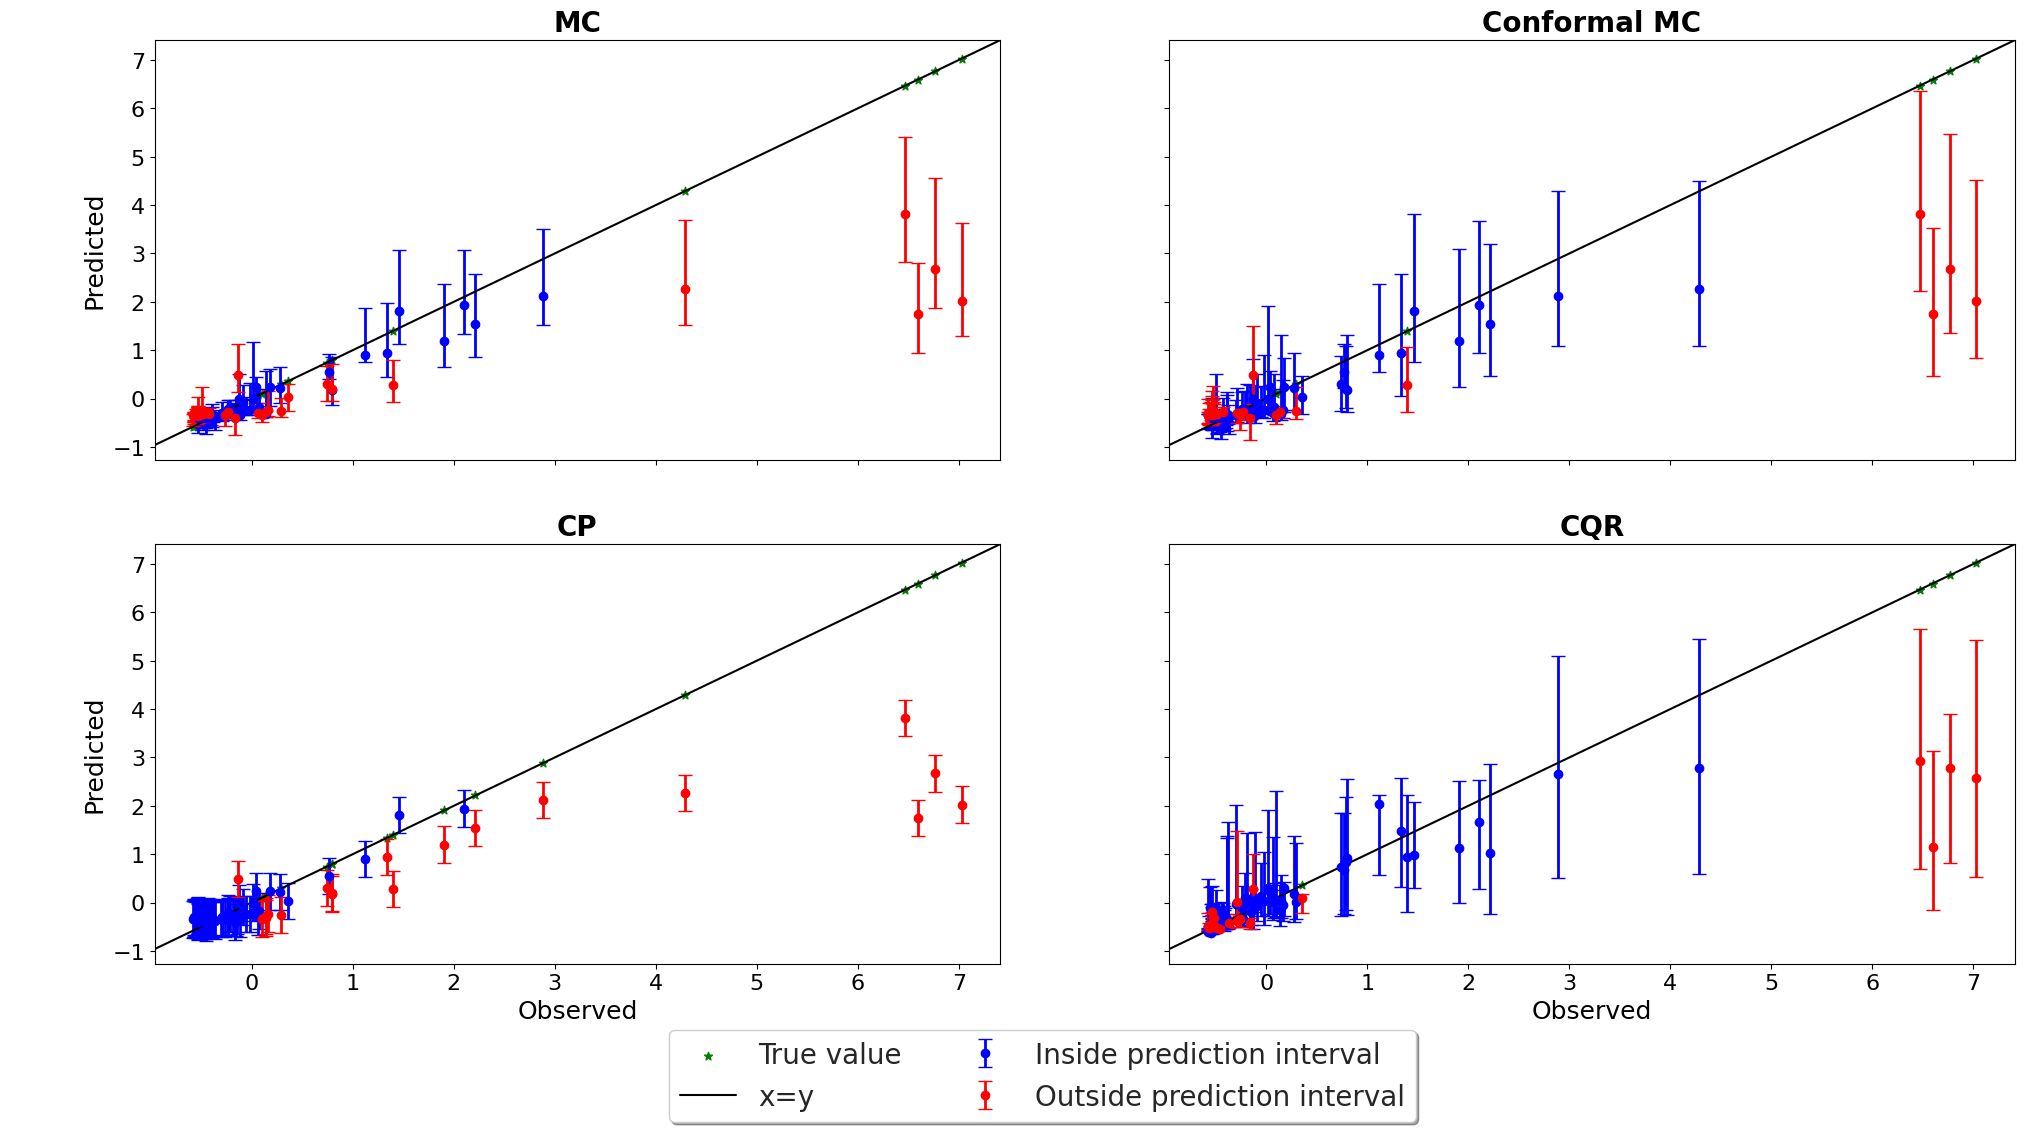

In [26]:
# Comparison between UQ methods (this show somewhat the Y-conditional coverage)
import seaborn as sns
fig, ax = plt.subplots(2,2,figsize = (24,12), sharey = True)
sns.set_style("whitegrid")
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]] #, ax[2,0]]
strategy = ["MC", "Conformal MC", "CP", "CQR"] #, "NGB"]
perc_obs_plot = 0.5
y_test_sorted = {}
y_pred_sorted = {}
y_lower_sorted = {}
y_upper_sorted = {}
Y_pred = np.array(mlp(X_test_tensor).detach())
y_test_sorted["Conformal MC"], y_pred_sorted["Conformal MC"], y_lower_sorted["Conformal MC"],y_upper_sorted["Conformal MC"]= sort_y_values2(Y_test, Y_pred, lower_conf, upper_conf)
y_test_sorted["MC"], y_pred_sorted["MC"], y_lower_sorted["MC"],y_upper_sorted["MC"]= sort_y_values2(Y_test, Y_pred, lower_mc, upper_mc)
y_test_sorted["CQR"], y_pred_sorted["CQR"], y_lower_sorted["CQR"],y_upper_sorted["CQR"]= sort_y_values(Y_test, Y_pred_cqr, y_pis)
y_test_sorted["NGB"], y_pred_sorted["NGB"], y_lower_sorted["NGB"],y_upper_sorted["NGB"]= sort_y_values2(Y_test, Y_pred_ng, lower_ng, upper_ng)
y_test_sorted["CP"], y_pred_sorted["CP"], y_lower_sorted["CP"],y_upper_sorted["CP"]= sort_y_values2(Y_test, y_pred_test, lower_cp, upper_cp)


random_state = 3
rng = np.random.default_rng(random_state)
num_plots = rng.choice(len(Y_test), int(perc_obs_plot*len(Y_test)), replace=False)
for idx, (axis, strat) in enumerate(zip(axs, strategy)):
    plot_prediction_intervals(
    strat,
    axis,
    y_test_sorted[strat],
    y_pred_sorted[strat],
    y_lower_sorted[strat],
    y_upper_sorted[strat],
    10,
    2,
    num_plots # num_plots
                )
lines_labels = [axis.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(_, []) for _ in zip(*lines_labels)]
plt.legend(
                      lines[:2] + lines[-2:], labels[:2] + labels[-2:],
                      loc='upper center',
                      bbox_to_anchor=(-0.15, -0.125),
                      fancybox=True,
                      shadow=True,
                      ncol=2, fontsize = 20
                  )
for ax in ax.flat:
    ax.label_outer()
plt.show()